<a href="https://colab.research.google.com/github/jeonbyeongguk/cuckoobee/blob/main/lAIbootcamp/Project/oyal_customer_Prediction_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# loyal cystomer Prediction Machine Learning Model

# Import libraries

In [1]:
import sys

if "google.colab" in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install xgboost==1.0
    !pip install shap
    


import xgboost
import warnings

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 327 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 16.8 MB/s 
     |████████████████████████████████| 133 kB 29.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=dd4fcb0977d91648e2038d1337b60db031c2da429c70a4442a401f90723905b2
  Stored in directory: /root/.cache/pip/wheels/85/ac/25/ffcd87ef8f9b1eec324fdf339359be71f22612459d8c75d89c
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 5.7.16 r

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.7 MB 15 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 33.6 MB/s 


In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
plt.style.use(['seaborn-whitegrid'])

# Import data

In [3]:
# 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# 압축해제 후 만들어진 폴더로 이동합니다.
%cd /content/drive/MyDrive/colab_data/olist/olist

# csv 파일들을 프린트합니다
from glob import glob
for filename in glob('*.csv'):
    print(filename)

# 각 파일의 shape, head를 출력하는 함수
from IPython.display import display
import pandas as pd

def preview():
    for filename in glob('*.csv'):
        df = pd.read_csv(filename)
        #print(filename, df.shape)
        #print(filename, df.columns)
        #display(df.head())
        #print('\n')

preview()

/content/drive/MyDrive/colab_data/olist/olist
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_orders_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv
rfm_k3.csv


In [5]:
customers = pd.read_csv('olist_customers_dataset.csv')

orders = pd.read_csv('olist_orders_dataset.csv', 
                     parse_dates=[
                         'order_purchase_timestamp', 
                         'order_approved_at', 
                         'order_delivered_carrier_date',
                         'order_delivered_customer_date',
                         'order_estimated_delivery_date'
                     ]
                    )

order_items = pd.read_csv('olist_order_items_dataset.csv', 
                          parse_dates=[
                              'shipping_limit_date'
                          ]
                         )
order_payments = pd.read_csv('olist_order_payments_dataset.csv')

order_geolocation = pd.read_csv('olist_geolocation_dataset.csv', 
                          parse_dates=[
                              'geolocation_zip_code_prefix',
                              'geolocation_lat',
                              'geolocation_lng'
                          ]
)
order_geolocation.rename(columns={'geolocation_zip_code_prefix': 'customer_zip_code_prefix'},inplace=True)

In [6]:
dfs = [customers, orders, order_items, order_payments, order_geolocation]

# Print shape of our datasets
for df in dfs:
    print(df.shape)

(99441, 5)
(99441, 8)
(112650, 7)
(103886, 5)
(1000163, 5)


# EDA

In [7]:
df

customer_zip_code_prefix      geolocation_lat     geolocation_lng  \
0                          01037   -23.54562128115268  -46.63929204800168   
1                          01046  -23.546081127035535  -46.64482029837157   
2                          01046   -23.54612896641469  -46.64295148361138   
3                          01041    -23.5443921648681  -46.63949930627844   
4                          01035  -23.541577961711493  -46.64160722329613   
...                          ...                  ...                 ...   
1000158                    99950   -28.06863887662893  -52.01070524698279   
1000159                    99900  -27.877125117712357  -52.22488216264145   
1000160                    99950   -28.07185541645192  -52.01471586864233   
1000161                    99980  -28.388931876600495  -51.84687132274168   
1000162                    99950   -28.07010363149126  -52.01865772856674   

        geolocation_city geolocation_state  
0              sao paulo                SP  
1              sao paulo                SP  
2              sao paulo                SP  
3              sao paulo                SP  
4              sao paulo                SP  
...                  ...               ...  
1000158         tapejara                RS  
1000159   getulio vargas                RS  
1000160         tapejara                RS  
1000161  david canabarro                RS  
1000162         tapejara                RS  

[1000163 rows x 5 columns]

In [8]:
# Merge 4 datasets into 1 dataframe
df1 = order_items.merge(order_payments, on='order_id')
df2 = df1.merge(orders, on='order_id')
df = df2.merge(customers, on='customer_id')

In [9]:
# 전처리 함수 
def EDA(df):
  df = df[df.order_status == 'delivered']
  return df
df = EDA(df)

In [10]:
df.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

  shipping_limit_date  price  freight_value  payment_sequential payment_type  \
0 2017-09-19 09:45:35   58.9          13.29                   1  credit_card   
1 2017-05-03 11:05:13  239.9          19.93                   1  credit_card   
2 2018-01-18 14:48:30  199.0          17.87                   1  credit_card   

   payment_installments  ...  order_status order_purchase_timestamp  \
0                     2  ...     delivered      2017-09-13 08:59:02   
1                     3  ...     delivered      2017-04-26 10:53:06   
2                     5  ...     delivered      2018-01-14 14:33:31   

    order_approved_at order_delivered_carrier_date  \
0 2017-09-13 09:45:35          2017-09-19 18:34:16   
1 2017-04-26 11:05:13          2017-05-04 14:35:00   
2 2018-01-14 14:48:30          2018-01-16 12:36:48   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-09-20 23:43:48                    2017-09-29   
1           2017-05-12 16:04:24                    2017-05-15   
2           2018-01-22 13:19:16                    2018-02-05   

                 customer_unique_id customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                    28013   
1  eb28e67c4c0b83846050ddfb8a35d051                    15775   
2  3818d81c6709e39d06b2738a8d3a2474                    35661   

           customer_city  customer_state  
0  campos dos goytacazes              RJ  
1        santa fe do sul              SP  
2          para de minas              MG  

[3 rows x 22 columns]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115035 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115035 non-null  object        
 1   order_item_id                  115035 non-null  int64         
 2   product_id                     115035 non-null  object        
 3   seller_id                      115035 non-null  object        
 4   shipping_limit_date            115035 non-null  datetime64[ns]
 5   price                          115035 non-null  float64       
 6   freight_value                  115035 non-null  float64       
 7   payment_sequential             115035 non-null  int64         
 8   payment_type                   115035 non-null  object        
 9   payment_installments           115035 non-null  int64         
 10  payment_value                  115035 non-null  float64       
 11  

In [12]:
df.isnull().sum()

order_id                          0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
payment_sequential                0
payment_type                      0
payment_installments              0
payment_value                     0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
dtype: int64

# RFM 분석
RFM 프레임워크를 사용하여 고객 세분화 모델을 구축할 것입니다. RFM은 최근, 빈도, 통화 가치를 나타냅니다. 이를 통해 다음과 같은 세그먼트를 생성할 수 있습니다.

- Low Value(0): 다른 고객에 비해 활동량이 적고 구매 빈도가 높지 않으며 수익이 매우 낮은 고객입니다.
- Mid Value(1): 모든 지표가 중간이며 플랫폼을 적당히 사용하고 적당한 수익을 창출합니다.
- High Value(2): 우리가 잃고 싶지 않은 그룹으로 높은 수익과 빈도를 가지며 사용 빈도는 다양합니다.

## RFM 전처리
최근 고객이 마지막으로 구매한 날짜를 찾아 계산합니다. 비활성 일수를 구한 후 K-평균 군집화를 적용하여 각 고객에게 최근 점수를 할당할 수 있습니다.

In [19]:
# 고객별 가장 최근에 구매한 날짜 구하기
recency = df[['customer_unique_id','order_purchase_timestamp']].copy()
recency = recency.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_timestamp']

# 비활성화일수 계산
recency['inactive_days'] = (recency['last_purchase_timestamp'].max()- recency['last_purchase_timestamp']).dt.days
recency.drop(columns='last_purchase_timestamp', inplace=True)

# 구매 빈도 
frequency = df[['customer_unique_id','order_id', 'payment_value']].copy()
frequency = frequency.groupby('customer_unique_id')['order_id'].count().reset_index()
frequency.columns = ['customer_unique_id', 'number_of_orders']

# 지출액
monetary = df[['customer_unique_id', 'payment_value']].copy()
monetary = monetary.groupby('customer_unique_id')['payment_value'].sum().reset_index()

# rfm 하나로 합치기
rfm = recency.merge(frequency, on='customer_unique_id')
rfm = rfm.merge(monetary, on='customer_unique_id')
rfm = rfm[~(rfm['inactive_days'] == 0)]

RFM의 분포를 확인해보겠습니다.

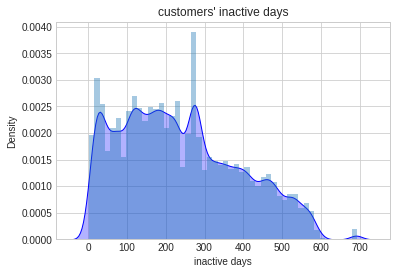

In [20]:
sns.distplot(rfm['inactive_days'],bins=50,kde=True,
kde_kws={"color": "b", "alpha":0.3, "linewidth": 1, "shade":True })
plt.xlabel('inactive days')
plt.ylabel('Density')
plt.title("customers' inactive days");

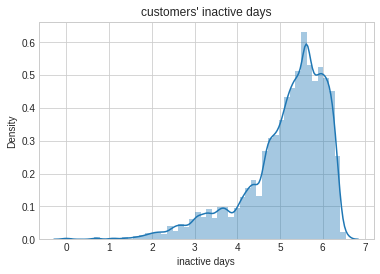

In [21]:
recency_log =  np.log(rfm['inactive_days'])
sns.distplot(recency_log)
plt.xlabel('inactive days')
plt.ylabel('Density')
plt.title("customers' inactive days");

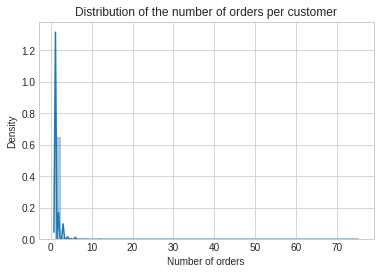

In [22]:
sns.distplot(rfm['number_of_orders']);
plt.xlabel('Number of orders')
plt.ylabel('Density')
plt.title("Distribution of the number of orders per customer");

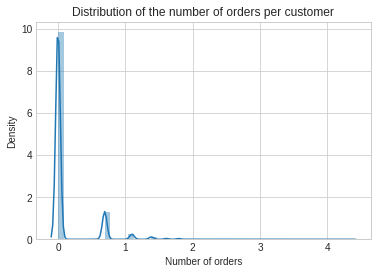

In [23]:
sns.distplot(np.log(rfm['number_of_orders']));
plt.xlabel('Number of orders')
plt.ylabel('Density')
plt.title("Distribution of the number of orders per customer");

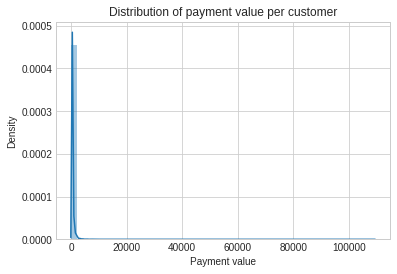

In [24]:
sns.distplot(rfm['payment_value'])
plt.xlabel('Payment value')
plt.ylabel('Density')
plt.title('Distribution of payment value per customer');

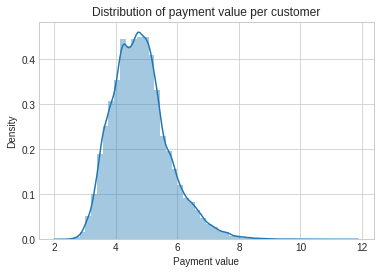

In [25]:
sns.distplot(np.log(rfm['payment_value']))
plt.xlabel('Payment value')
plt.ylabel('Density')
plt.title('Distribution of payment value per customer');

왼쪽으로 치우쳐진 형태로 로그 변환을 적용시키겠습니다.

##  K-means Clustering

### Recency clustering

Recency(비활동일수)는 클수록 충성고객과 상관관계가 떨어지지만 구매 빈도와 지출 금액은 클수록 충성 고객일 확률이 높습니다. 

따라서 비활동지수으로 클러스터링, 구매 빈도와 지출금액으로 클러스터링을 한 후 각 클러스터를 합친 다음 3그룹으로 나누겠습니다. 

In [26]:
rfm_log = rfm.copy()
rfm_log['inactive_days'] = np.log(rfm['inactive_days'])
rfm_log['number_of_orders'] =np.log(rfm['number_of_orders'])
rfm_log['payment_value']  = np.log(rfm['payment_value'])
rfm_log_a = rfm_log[['customer_unique_id','inactive_days']]
rfm_log_b = rfm_log[['customer_unique_id','number_of_orders','payment_value']]

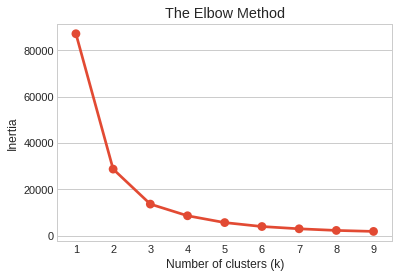

In [419]:
#Elbow Method으로 k값 찾기
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(rfm_log_a.set_index('customer_unique_id'))
    inertia[k] = km.inertia_

# 결과 시각화
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
sns.pointplot(x=list(inertia.keys()), y=list(inertia.values()))
plt.show()

최적의 군집화 k는 3개입니다. 하지만 Frequency와 Monetary의 k값이 4개이므로 일관성을 위해서 4개를 사용하겠습니다. 

In [27]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(rfm_log_a.set_index('customer_unique_id'))
rfm_log_a['cluster'] = km.labels_
rfm_log_a.head()

customer_unique_id  inactive_days  cluster
0  0000366f3b9a7992bf8c76cfdf3221e2       4.709530        2
1  0000b849f77a49e4a4ce2b2a4ca5be3f       4.736198        2
2  0000f46a3911fa3c0805444483337064       6.284134        0
3  0000f6ccb0745a6a4b88665a16c9f078       5.768321        0
4  0004aac84e0df4da2b147fca70cf8255       5.659482        0

In [494]:
rfm_log_a.groupby('cluster')['inactive_days'].describe().sort_values(by='mean')

count      mean       std       min       25%       50%       75%  \
cluster                                                                        
1         6973.0  2.742917  0.603127  0.000000  2.484907  2.944439  3.178054   
3        12766.0  4.097566  0.332028  3.433987  3.806662  4.158883  4.369448   
2        32661.0  5.105613  0.256645  4.605170  4.890349  5.135798  5.327876   
0        40928.0  5.913171  0.249936  5.509388  5.673323  5.905362  6.122493   

              max  
cluster            
1        3.401197  
3        4.595120  
2        5.505332  
0        6.542472

직관적으로 클러스터의 라벨을 이해하기 힘드므로 
클러스터 0번을 사용적 제일 많은 고객으로 할당하고 클러스터 3번을 가장 비활성화된 고객에게 할당해 보겠습니다. 

In [28]:
rfm_log_a_cluster = rfm_log_a.groupby('cluster')['inactive_days'].mean().reset_index()
rfm_log_a_cluster = rfm_log_a_cluster.sort_values(by='inactive_days').reset_index(drop=True)
rfm_log_a_cluster['index'] = np.arange(0,4)
rfm_log_a_cluster.set_index('cluster', inplace=True)
cluster_dict = rfm_log_a_cluster['index'].to_dict()
rfm_log_a['cluster'].replace(cluster_dict, inplace=True)

In [586]:
rfm_log_a.groupby('cluster')['inactive_days'].describe().sort_values(by='mean')

count      mean       std       min       25%       50%       75%  \
cluster                                                                        
0         6973.0  2.742917  0.603127  0.000000  2.484907  2.944439  3.178054   
1        12766.0  4.097566  0.332028  3.433987  3.806662  4.158883  4.369448   
2        32661.0  5.105613  0.256645  4.605170  4.890349  5.135798  5.327876   
3        40928.0  5.913171  0.249936  5.509388  5.673323  5.905362  6.122493   

              max  
cluster            
0        3.401197  
1        4.595120  
2        5.505332  
3        6.542472

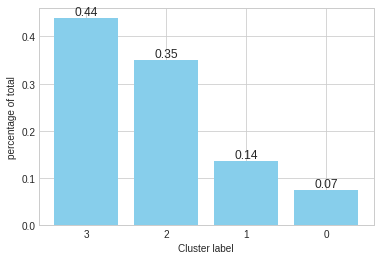

In [64]:
import matplotlib.pyplot as plt

x = ['3','2','1','0']
y = list(rfm_log_a['cluster'].value_counts(normalize=True))
bar = plt.bar(x, y, color = 'skyblue')
plt.xlabel('Cluster label')
plt.ylabel('percentage of total')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)

plt.show()

### Frequency & Monetary clustering

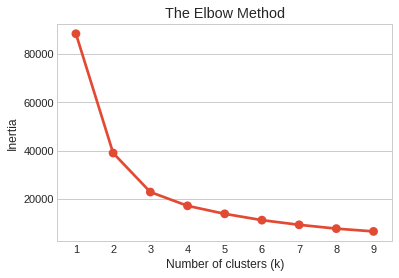

In [425]:
#Elbow Method으로 k값 찾기
inertia = {}

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(rfm_log_b.set_index('customer_unique_id'))
    inertia[k] = km.inertia_

# 결과 시각화
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
sns.pointplot(x=list(inertia.keys()), y=list(inertia.values()))
plt.show()

In [66]:
km = KMeans(n_clusters=4, random_state=42)
km.fit(rfm_log_b.set_index('customer_unique_id'))
rfm_log_b['cluster'] = km.labels_
rfm_log_b.head()

customer_unique_id  number_of_orders  payment_value  cluster
0  0000366f3b9a7992bf8c76cfdf3221e2               0.0       4.955123        3
1  0000b849f77a49e4a4ce2b2a4ca5be3f               0.0       3.302849        1
2  0000f46a3911fa3c0805444483337064               0.0       4.456902        3
3  0000f6ccb0745a6a4b88665a16c9f078               0.0       3.775516        1
4  0004aac84e0df4da2b147fca70cf8255               0.0       5.282645        0

In [590]:
rfm_log_b.groupby('cluster')['payment_value'].describe().sort_values(by='mean')

count      mean       std       min       25%       50%       75%  \
cluster                                                                        
1        24965.0  3.767825  0.307396  2.260721  3.565581  3.811761  4.026601   
0        34415.0  4.613355  0.241034  4.138042  4.409520  4.621339  4.817778   
2        33948.0  5.748928  0.672057  4.769413  5.243703  5.546856  6.062878   

               max  
cluster             
1         4.192832  
0         5.037277  
2        11.601967

In [67]:
rfm_log_b_cluster = rfm_log_b.groupby('cluster')['payment_value'].mean().reset_index()
rfm_log_b_cluster = rfm_log_b_cluster.sort_values(by='payment_value', ascending=False).reset_index(drop=True)
rfm_log_b_cluster['index'] = np.arange(0,4)
rfm_log_b_cluster.set_index('cluster', inplace=True)
cluster_dict = rfm_log_b_cluster['index'].to_dict()
rfm_log_b['cluster'].replace(cluster_dict, inplace=True)
rfm_log_b.groupby('cluster')['payment_value'].describe().sort_values(by='mean')

count      mean       std       min       25%       50%       75%  \
cluster                                                                        
3        24965.0  3.767825  0.307396  2.260721  3.565581  3.811761  4.026601   
2        34415.0  4.613355  0.241034  4.138042  4.409520  4.621339  4.817778   
1        25192.0  5.429953  0.296023  4.769413  5.178914  5.371545  5.648023   
0         8756.0  6.666654  0.603376  5.230681  6.253329  6.530156  6.936809   

               max  
cluster             
3         4.192832  
2         5.037277  
1         6.211162  
0        11.601967

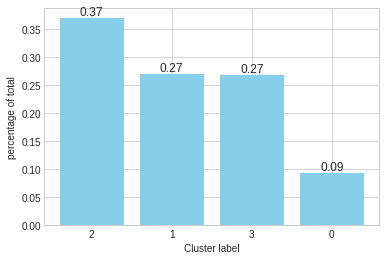

In [69]:
import matplotlib.pyplot as plt

x = ['2','1','3','0']
y = list(rfm_log_b['cluster'].value_counts(normalize=True))
bar = plt.bar(x, y, color = 'skyblue')
plt.xlabel('Cluster label')
plt.ylabel('percentage of total')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)

plt.show()

In [71]:
# 종합 점수 내기
a=rfm_log_a.copy()
b=rfm_log_b.copy()
a['overall_score'] = a['cluster'] + b['cluster']
a.drop('cluster',axis=1, inplace=True)
b.drop('cluster',axis=1,inplace=True)
rfm_k4  = b.merge(a,on='customer_unique_id')

# 2,1,0 순으로 충성 고객 분류 
rfm_k4['segment'] = rfm_k4['overall_score'].map(lambda x: 2 if x < 3 else (1 if x < 5 else 0))

3개의 그룹으로 보는 **비활동일수, 주문 빈도, 구매 금액** 등의 평균을 살펴 봅시다. 

In [73]:
rfm_k4.groupby('segment')[['inactive_days', 'number_of_orders', 'payment_value']].mean().sort_values(by='payment_value')

inactive_days  number_of_orders  payment_value
segment                                                
0             5.717160          0.037540       4.135671
1             5.085544          0.143925       5.046980
2             3.808719          0.324223       5.734507

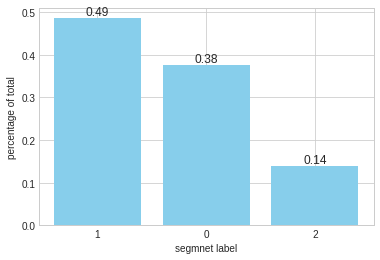

In [76]:
import matplotlib.pyplot as plt

x = ['1','0','2']
y = list(rfm_k4['segment'].value_counts(normalize=True))
bar = plt.bar(x, y, color = 'skyblue')
plt.xlabel('segmnet label')
plt.ylabel('percentage of total')
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)

plt.show()

2번은 전체의 13.9%으로 활동빈도가 높고 자주 구매하며 지출액이 큰 **충성고객**입니다. 

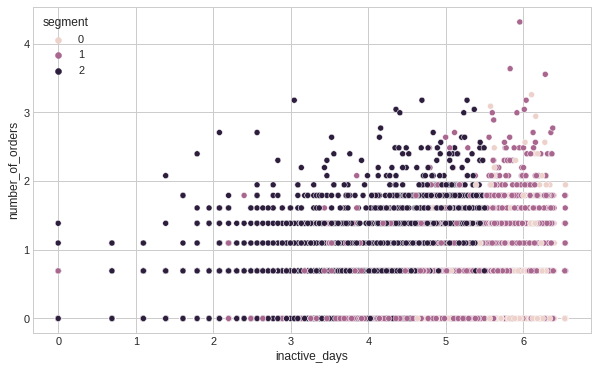

In [604]:
# 비활동일수와 구매 빈도 상관관계
fig , ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x ='inactive_days', y = 'number_of_orders', hue='segment',data=rfm_k4);

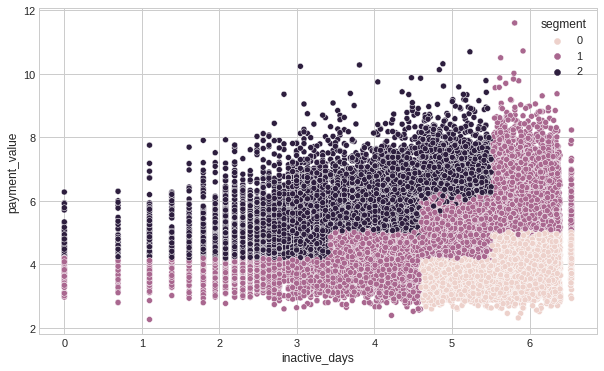

In [605]:
# 비활동일수와 구매 금액 상관관계
fig , ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x ='inactive_days', y = 'payment_value', hue='segment',data=rfm_k4);

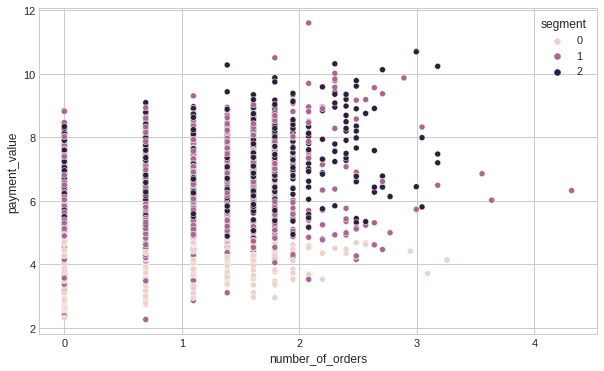

In [606]:
# 구매 빈도와 구매 금액의 상관관계
fig , ax = plt.subplots(figsize=(10,6))
sns.scatterplot(x ='number_of_orders', y = 'payment_value', hue='segment',data=rfm_k4);

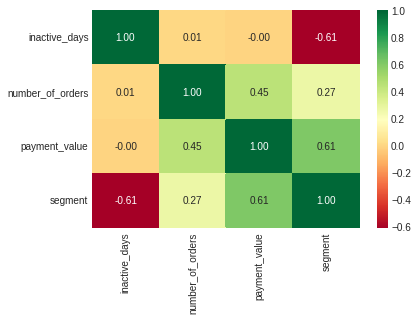

In [78]:
# 종합 점수와 3개의 요인의 상관관계 
relative_imp = rfm_k4[['inactive_days', 'number_of_orders', 'payment_value','segment']].corr()
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap = "RdYlGn");

## 3차원 클러스터링 그래프

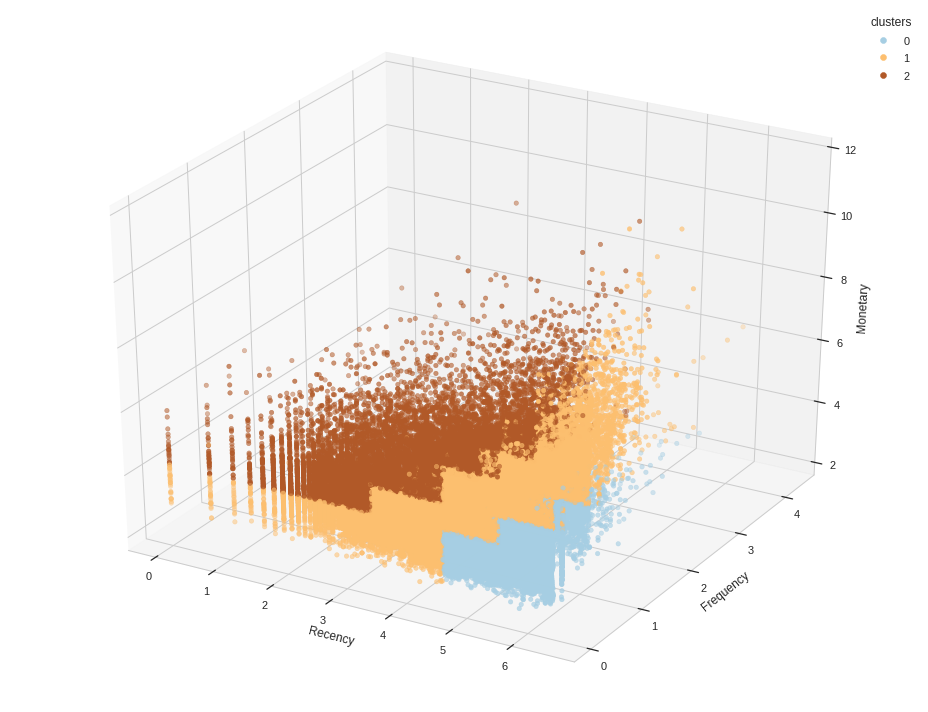

In [609]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(xs = rfm_k4.inactive_days, ys = rfm_k4.number_of_orders, zs = rfm_k4.payment_value, c=rfm_k4.segment,cmap=plt.cm.Paired)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.legend(*sc.legend_elements(), title='clusters',loc = 'best')
plt.tight_layout()
plt.show()

- 0: 비활동일수가 많고 구매 빈도가 적으로 구매 금액도 적은 그룹
- 1: 비활동일수가 다양하지만 구매 빈도가 적당하고 구매 금액도 어느정도 있는  중간 그룹
- 2: 비활동일수가 적고 구매 빈도가 많으며 많은 구매 금액이 큰 그룹

  따라서 라벨 2번의 고객들이 충성고객으로 볼 수 있습니다. 


In [312]:
import plotly.express as px
from plotly.offline import plot
fig = px.scatter_3d(rfm, x = 'inactive_days', y='number_of_orders', z='payment_value',
              color='cluster', opacity = 0.8, size='payment_value', size_max=20)


#plot(fig, filename='plotly-3d-scatter.html', auto_open=False)
#fig.show()

'plotly-3d-scatter.html'

# feature engineering

In [13]:
# 데이터 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/colab_data/olist/olist.csv',index_col=0)
df.head(3)

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   

   shipping_limit_date  price  freight_value  payment_sequential payment_type  \
0  2017-09-19 09:45:35   58.9          13.29                   1  credit_card   
1  2017-05-03 11:05:13  239.9          19.93                   1  credit_card   
2  2018-01-18 14:48:30  199.0          17.87                   1  credit_card   

   payment_installments  ...  order_status order_purchase_timestamp  \
0                     2  ...     delivered      2017-09-13 08:59:02   
1                     3  ...     delivered      2017-04-26 10:53:06   
2                     5  ...     delivered      2018-01-14 14:33:31   

     order_approved_at order_delivered_carrier_date  \
0  2017-09-13 09:45:35          2017-09-19 18:34:16   
1  2017-04-26 11:05:13          2017-05-04 14:35:00   
2  2018-01-14 14:48:30          2018-01-16 12:36:48   

  order_delivered_customer_date order_estimated_delivery_date  \
0           2017-09-20 23:43:48           2017-09-29 00:00:00   
1           2017-05-12 16:04:24           2017-05-15 00:00:00   
2           2018-01-22 13:19:16           2018-02-05 00:00:00   

                 customer_unique_id customer_zip_code_prefix  \
0  871766c5855e863f6eccc05f988b23cb                    28013   
1  eb28e67c4c0b83846050ddfb8a35d051                    15775   
2  3818d81c6709e39d06b2738a8d3a2474                    35661   

           customer_city  customer_state  
0  campos dos goytacazes              RJ  
1        santa fe do sul              SP  
2          para de minas              MG  

[3 rows x 22 columns]

In [15]:
rfm_k3 = pd.read_csv('/content/drive/MyDrive/colab_data/olist/rfm_k4.csv',index_col=0)
rfm_k3.head(3)

customer_unique_id  number_of_orders  payment_value  \
0  0000366f3b9a7992bf8c76cfdf3221e2               0.0       4.955123   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               0.0       3.302849   
2  0000f46a3911fa3c0805444483337064               0.0       4.456902   

   inactive_days  overall_score  segment  
0       4.709530              4        1  
1       4.736198              5        0  
2       6.284134              5        0

In [16]:
# target 칼럼 생성 
rfm_k3['loyal_customer'] = rfm_k3['segment'] == 2
rfm_k3['loyal_customer'].replace({False:0,True:1},inplace=True)
rfm_k3.drop(['segment','number_of_orders' ,'payment_value', 'inactive_days','overall_score'],axis=1,inplace=True)

# 시간 칼럼 모음
df_time = df[['customer_unique_id','order_approved_at','order_delivered_carrier_date',
            'order_delivered_customer_date','order_estimated_delivery_date','shipping_limit_date']]

# feature enginnering
def enginner(df):
  df.customer_unique_id = df.customer_unique_id.drop_duplicates()
  df =df.drop(['order_purchase_timestamp','order_approved_at','shipping_limit_date',
               'order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], axis =1)
  df = rfm_k3.merge(df,on='customer_unique_id')
  return df



df = enginner(df)

In [17]:
df.head(3)

customer_unique_id  loyal_customer  \
0  0000366f3b9a7992bf8c76cfdf3221e2               0   
1  0000b849f77a49e4a4ce2b2a4ca5be3f               0   
2  0000f46a3911fa3c0805444483337064               0   

                           order_id  order_item_id  \
0  e22acc9c116caa3f2b7121bbb380d08e              1   
1  3594e05a005ac4d06a72673270ef9ec9              1   
2  b33ec3b699337181488304f362a6b734              1   

                         product_id                         seller_id  price  \
0  372645c7439f9661fbbacfd129aa92ec  da8622b14eb17ae2831f4ac5b9dab84a  129.9   
1  5099f7000472b634fea8304448d20825  138dbe45fc62f1e244378131a6801526   18.9   
2  64b488de448a5324c4134ea39c28a34b  3d871de0142ce09b7081e2b9d1733cb1   69.0   

   freight_value  payment_sequential payment_type  payment_installments  \
0          12.00                   1  credit_card                     8   
1           8.29                   1  credit_card                     1   
2          17.22                   1  credit_card                     8   

   payment_value                       customer_id order_status  \
0         141.90  fadbb3709178fc513abc1b2670aa1ad2    delivered   
1          27.19  4cb282e167ae9234755102258dd52ee8    delivered   
2          86.22  9b3932a6253894a02c1df9d19004239f    delivered   

   customer_zip_code_prefix customer_city customer_state  
0                      7787       cajamar             SP  
1                      6053        osasco             SP  
2                     88115      sao jose             SC

In [18]:
rfm_k3.head(3)

customer_unique_id  loyal_customer
0  0000366f3b9a7992bf8c76cfdf3221e2               0
1  0000b849f77a49e4a4ce2b2a4ca5be3f               0
2  0000f46a3911fa3c0805444483337064               0

In [19]:
rfm_k3['loyal_customer'].value_counts()

0    80357
1    12971
Name: loyal_customer, dtype: int64

### 데이터 누수 확인 

In [20]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(df, test_size=0.2, random_state=2)
train.shape, val.shape

((74662, 17), (18666, 17))

In [21]:
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

target = 'loyal_customer'
features = df.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipe = make_pipeline(
    OrdinalEncoder(), 
    DecisionTreeClassifier(max_depth=5, random_state=2)
)

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.8707810993249759


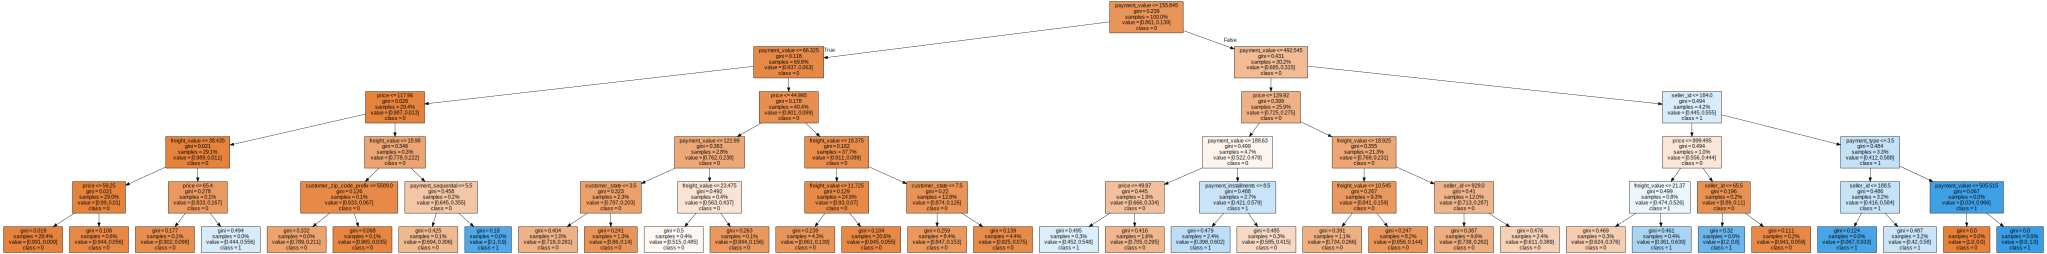

In [22]:
### 어떤 트리가 만들어졌는지 그려봅시다
import graphviz
from sklearn.tree import export_graphviz

tree = pipe.named_steps['decisiontreeclassifier']

dot_data = export_graphviz(
    tree,
    feature_names=X_train.columns, 
    class_names=y_train.unique().astype(str), 
    filled=True, 
    proportion=True
)

graphviz.Source(dot_data)

# 머신러닝 모델링

### 초기 설정

In [23]:
from sklearn.metrics import roc_curve , roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from category_encoders import OneHotEncoder ,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

train.shape, val.shape , test.shape

((59729, 17), (14933, 17), (18666, 17))

In [25]:
target = 'loyal_customer'
features = df.columns.drop([target])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [26]:
# auc_score 함수
def plot_roc(model,y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # roc_curve(타겟값, prob of 1)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_proba)

    # threshold 최대값의 인덱스, np.argmax()
    optimal_idx = np.argmax(tpr1 - fpr1)
    optimal_threshold = thresholds1[optimal_idx]

    # threshold 최대값으로 설정 
    y_pred_optimal = y_pred_proba >= optimal_threshold

    auc_score = roc_auc_score(y_val, y_pred_optimal)
    fpr, tpr, _ = roc_curve(y_val, y_pred_optimal)
    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))

    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label="Model")
    plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
    plt.xlabel("False Positive Rate", size=12)
    plt.ylabel("True Positive Rate", size=12)
    plt.title("ROC curve")
    plt.legend(prop={"size": 12})
    print("auc_score :",auc_score*100)
    plt.show()


In [27]:
# auc 그래프와 confusion_matrix 그래프 함수
def conf_plot(model,X_train,y_train,X_val,y_val):
  model.fit(X_train, y_train)

  y_train_pred = model.predict(X_train)
  y_val_pred = model.predict(X_val)

  # roc_curve(타겟값, prob of 1)
  y_pred_proba = model.predict_proba(X_val)[:, 1]
  fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_proba)

  # threshold 최대값의 인덱스, np.argmax()
  optimal_idx = np.argmax(tpr1 - fpr1)
  optimal_threshold = thresholds1[optimal_idx]

  # threshold 최대값으로 설정 
  y_pred_optimal = y_pred_proba >= optimal_threshold

  print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal)*100 ,"%")
  print('최종 f1 score',f1_score(y_val, y_pred_optimal)*100 ,"%")
  print("\nConfusion matrix: \n")

  #Roc 그래프
  fig, ax = plt.subplots(1,2, figsize=(8,4))
  plot_confusion_matrix(model,X_train,y_train, ax=ax[0], values_format='d')
  ax[0].grid(False)
  ax[0].set_title('Train',fontsize=15)
  plot_confusion_matrix(model,X_val,y_val, ax=ax[1], values_format='d')
  ax[1].set_title('val',fontsize=15)
  ax[1].grid(False)
  plt.tight_layout()

In [28]:
# score 함수
def score(model,X_train,y_train,X_test,y_test):
  print('테스트 정확도: ', model.score(X_test, y_val)*100 ,"%")

## 기본 모델:SGDC model

In [29]:
baseline_accuracy_score = max(df['loyal_customer'].value_counts(normalize=True))
print("baseline accuracy score:", baseline_accuracy_score*100,'%')

baseline accuracy score: 86.10170581176068 %


최종 검증 정확도:  53.77352173039577 %
최종 f1 score 29.265293575161387 %

Confusion matrix: 



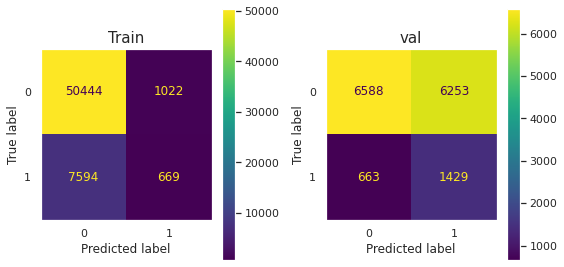

In [30]:
# SGDC 
sgdc = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    SGDClassifier(loss='log',
                      max_iter=5000,   #최대반복수
                      tol=1e-5,        # max_iter에 도달하지 않더라도 작업중단
                      random_state=2,  # 실행할 때마다 바뀌지 않게 초깃값
                      penalty='l2',    #penalty는 규제를 적용하겠다는 의미
                      alpha=0.001)
)


conf_plot(sgdc,X_train,y_train,X_val,y_val)

auc_score : 59.83673978084361 %


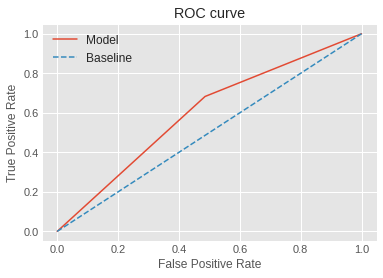

In [640]:
plot_roc(sgdc,y_val)

- 기준 모델의 정확도는 최빈값인 86.1%입니다. 
- 또한 가장 간단한 선형모델인 SDGC모델을 기준모델로 정하고 진행했습니다.
- 최빈값 기본모델의 정확도를 SDGC 모델이 넘지 못했다는 점을 기억하고 SDGC 모델의 정확도를 평가지표로 삼으며 이번 Modeling에서 유심히 볼 평가지표인 ‘AUC Score’를 Baseline으로 두고 진행하겠습니다.
-정확도, 정밀도와 재현율이 포함된 F1도 함께 확인하며 진행하지만 두가지 모두 반영하여 그래프를 점수화 한 AUC Score를 중점으로 두고 진행하겠습니다.


## DecisionTree model

최종 검증 정확도:  70.13326190316748 %
최종 f1 score 42.22797927461139 %

Confusion matrix: 



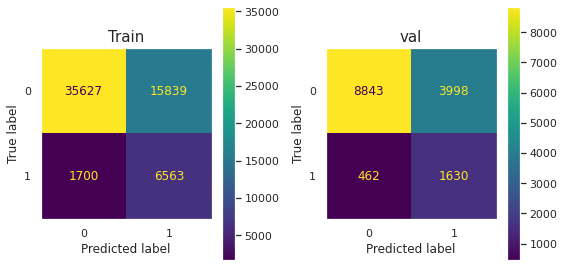

In [30]:
# class weights 계산
# n_samples / (n_classes * np.bincount(y))
custom = len(y_train)/(2*np.bincount(y_train))

# 파이프라인을 만들어 봅시다.
dt = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=5,
                           class_weight={False:custom[0],True:custom[1]},
                           #class_weight ='balanced',
                           random_state=2)
)


conf_plot(dt,X_train,y_train,X_val,y_val)

auc_score : 73.39061157326043


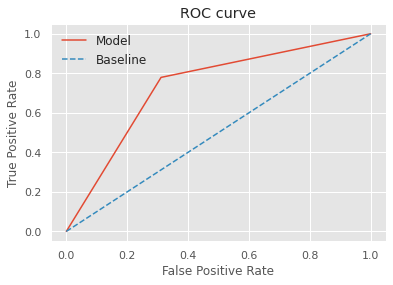

In [31]:
plot_roc(dt,y_val)

- 기본모델인 SDGC보다 정확도와 auc 점수가 크게 상승한 것을 알 수가 있습니다.

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

model_dt = dt.named_steps['decisiontreeclassifier']
enc = dt.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , max_depth=3
                          , feature_names=encoded_columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

특성 중요도

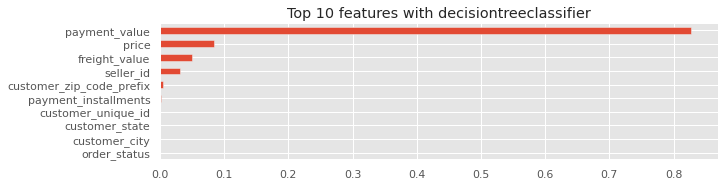

In [33]:
model_dt = dt.named_steps['decisiontreeclassifier']
enc = dt.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns
importances = pd.Series(model_dt.feature_importances_, encoded_columns)
n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with decisiontreeclassifier')
importances.sort_values()[-n:].plot.barh();

## Random forest model

최종 검증 정확도:  71.81410299337038 %
최종 f1 score 43.79756976899453 %

Confusion matrix: 



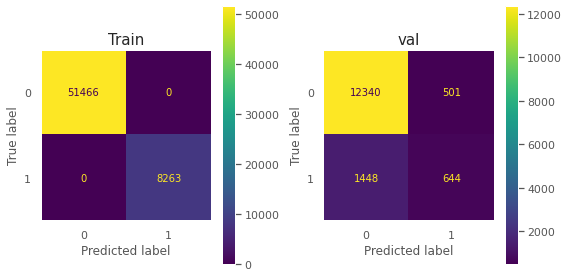

In [30]:
# Random forest model
rf = make_pipeline(
     OrdinalEncoder(),
    SimpleImputer(), 
    RandomForestClassifier()
)

conf_plot(rf,X_train,y_train,X_val,y_val)

auc_score : 73.4966574561079 %


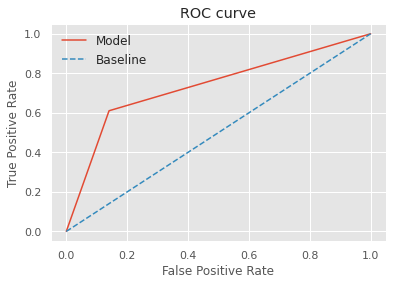

In [29]:
plot_roc(rf,y_val)

- 결정 트리 모델과 성능차이가 별로 없는 것을 알 수 있습니다. 

## Random Forest model + Randomized Search CV

In [701]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=2)
)
dists = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': randint(50, 500), 
    'randomforestclassifier__max_depth': [5, 10, 15, 20, None], 
    'randomforestclassifier__max_features': uniform(0, 1)
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=5, 
    cv=3, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)
print("Best CV F1", clf.best_score_)

pipe = clf.best_estimator_
y_val_pred = pipe.predict(X_val)
y_train_pred = pipe.predict(X_train)
print('검증 f1 score: ', f1_score(y_val, y_val_pred, average='binary'))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.3740247613406321, 'randomforestclassifier__n_estimators': 488, 'simpleimputer__strategy': 'mean'}
Best CV F1 0.8285491754065243
훈련 f1 score:  0.4608788853161844
검증 f1 score:  0.3232104121475054


최적 하이퍼파라미터:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__max_features': 0.3740247613406321, 'randomforestclassifier__n_estimators': 488, 'simpleimputer__strategy': 'mean'}
- Best CV F1 0.8285491754065243
- 검증 f1 score:  0.3232104121475054

최종 검증 정확도:  74.50612736891449 %
최종 f1 score 45.792396411789824 %

Confusion matrix: 



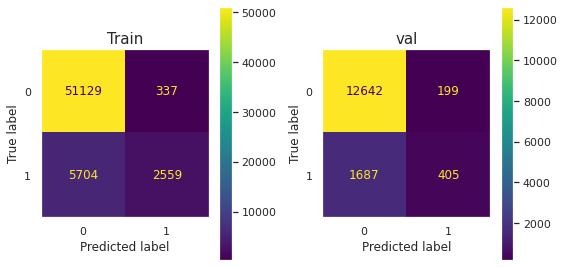

In [23]:
# Randomized Search CV 하이퍼파라미터 튜닝
rf_RSCV = make_pipeline(
     OrdinalEncoder(),
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(
        max_depth = 10,
        max_features = 0.3740247613406321,
        n_estimators = 488,
        n_jobs=-1, oob_score=True)
)

conf_plot(rf_RSCV,X_train,y_train,X_val,y_val)

auc_score : 75.4930989303949 %


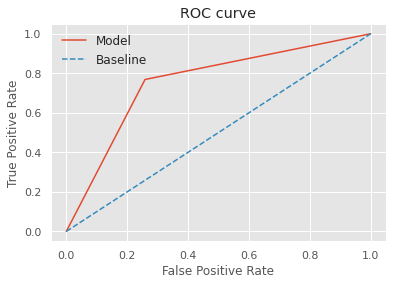

In [24]:
plot_roc(rf_RSCV,y_val)

- Randomized Search CV 하이퍼파라미터 튜닝을 통해 auc score 3점의 향상시킬 수 있었습니다.

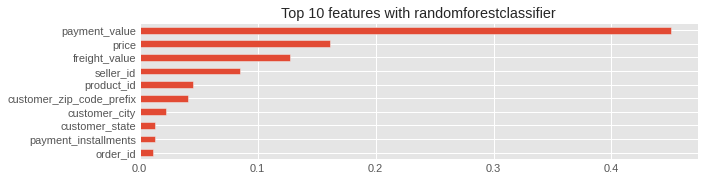

In [651]:
# 특성 중요도(ordinal)
rf_ord = rf_RSCV.named_steps['randomforestclassifier']
importances_ord = pd.Series(rf_ord.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with randomforestclassifier')
importances_ord.sort_values()[-n:].plot.barh();

- Random Forest 모델에서의 특성 중요도는 아래와 같습니다.
 - 지출액
 - 상품 가격
 - 운임 요금
 
이 중에서 충성고객과 지출액의 상관관계가 압도적으로 높은 것을 알 수 있습니다.

## Xgboost model

최종 검증 정확도:  80.6000133931561 %
최종 f1 score 52.21837374237176 %

Confusion matrix: 



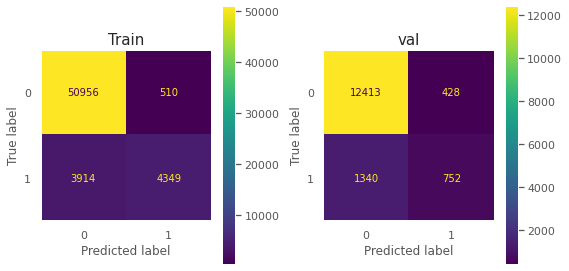

In [31]:
from xgboost import XGBClassifier

xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier()
)


conf_plot(xgb,X_train,y_train,X_val,y_val)

auc_score : 78.53626677991133 %


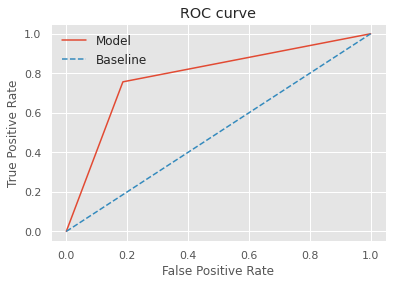

In [32]:
plot_roc(xgb,y_val)

- xgboost 모델이 Randomized Search CV 하이퍼파라미터 튜닝한 모델보다 auc score 3점 높은 것을 알 수 있습니다. 

### Xgboost model + RandomizedSearchCV

In [250]:
pipeline = make_pipeline(
  OrdinalEncoder(),
  XGBClassifier(
      objective='binary:logistic',
      eval_metric='error',
      n_estimators=300,
      #learning_rate=0.1,
      # tree_method='gpu_hist',
      scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
      n_jobs=-1
  )
)

hp = {
  #"simpleimputer__strategy" : ['mean', 'median', 'most_frequent'],
  "xgbclassifier__colsample_bytree":[0.25, 0.5],
  "xgbclassifier__min_child_weight":[4, 16],
  'xgbclassifier__n_estimators': randint(50, 500),
  "xgbclassifier__learning_rate":[0.01, 0.05, 0.1],
  "xgbclassifier__max_depth": [5, 10, 15, 20, None], 
    'xgbclassifier__max_features': uniform(0, 1)
}
clf = RandomizedSearchCV(
  estimator=pipeline,
  param_distributions=hp,
  n_iter=6,
  cv=4,
  scoring="roc_auc"
)


clf.fit(X_train, y_train);
print('최적 하이퍼파라미터: ', clf.best_params_)
print("Best CV F1", clf.best_score_)

xgb_rs = clf.best_estimator_
y_val_pred = xgb_rs.predict(X_val)
y_train_pred = xgb_rs.predict(X_train)
print('훈련 f1 score: ', f1_score(y_train, y_train_pred))
print('검증 f1 score: ', f1_score(y_val, y_val_pred))

최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 10, 'xgbclassifier__max_features': 0.2716264231227219, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__n_estimators': 335}
Best CV F1 0.8686702004554415
훈련 f1 score:  0.651877133105802
검증 f1 score:  0.528954802259887


최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 5, 'xgbclassifier__max_features': 0.6397629931229856, 'xgbclassifier__min_child_weight': 16}
- Best CV F1 0.8835618570276964
- 훈련 f1 score:  0.4899662229286708
- 검증 f1 score:  0.3709831371301305

최종 검증 정확도:  67.36087859103998 %
최종 f1 score 40.92121212121212 %

Confusion matrix: 



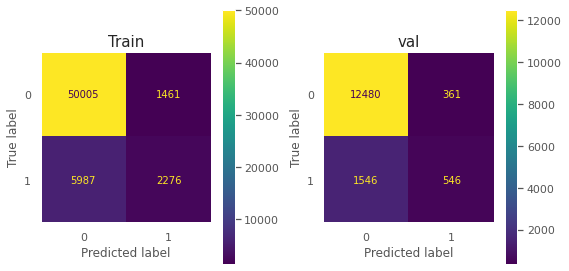

In [35]:
conf_plot(pipe,X_train,y_train,X_val,y_val)

auc_score : 72.93898174808434 %


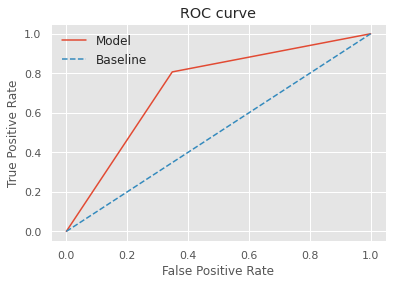

In [36]:
plot_roc(pipe,y_val)

- RandomizedSearchCV 에서 가장 좋은 모델을 통해 학습한 결과 auc 점수 72%으로 상당히 낮은 결과를 얻을 수 있었습니다. 

최종 검증 정확도:  80.88126967119803 %
최종 f1 score 54.385684614155615 %

Confusion matrix: 



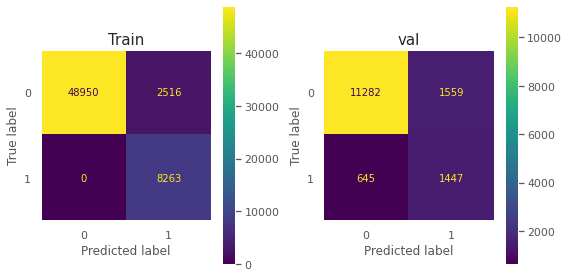

In [58]:
from xgboost import XGBClassifier

xgb_RSCV = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(  
                    min_child_weight =16
                  , n_estimators=172
                  , random_state=2
                  , n_jobs=-1
                  , max_depth= 20
                  , learning_rate=0.1
                  , colsample_bytree = 0.5
                  , max_features =  0.48639096261531867
                  ,scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum() *100
                 )
)


conf_plot(xgb_RSCV,X_train,y_train,X_val,y_val)

auc_score : 81.08061415372575 %


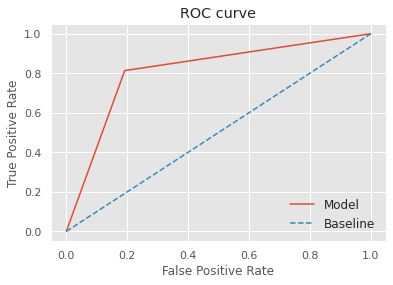

In [61]:
plot_roc(xgb_RSCV,y_val)

- Xgboost 모델에 RandomizedSearchCV 하이퍼파라미터 튜닝한 모델의 auc 점수는 3점의 소폭 상승한 결과를 알 수 있었습니다.

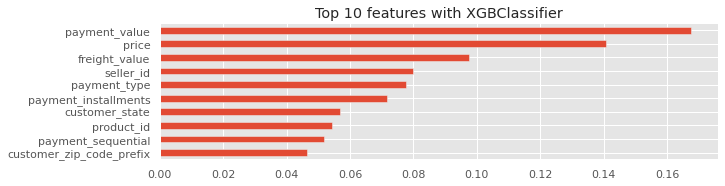

In [41]:
# 특성 중요도(ordinal)
xgb_ord = xgb_RSCV.named_steps['xgbclassifier']
importances_ord = pd.Series(xgb_ord.feature_importances_, X_train.columns)

n = 10
plt.figure(figsize=(10,n/4))
plt.title(f'Top {n} features with XGBClassifier')
importances_ord.sort_values()[-n:].plot.barh();

- Random Forest와 마찬가지로 **지출액,상품가격,운임요금** 순으로 충성고객과 상관관계를 보이고 있습니다. 
- 하지만 Random Forest는 지출액에 큰 의존성을 보였지만 xgboost는 상품가격에 영향력이 더 커졌습니다. 

### xgboost model + Early Stopping

In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

xgb_RSCV_e =  XGBClassifier(  
                    min_child_weight =16
                  , n_estimators=172
                  , random_state=42
                  , n_jobs=-1
                  , max_depth= 20
                  , learning_rate=0.1
                  , colsample_bytree = 0.5
                  #, max_features =  0.48639096261531867
                  #, scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum() *100
                 )

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

xgb_RSCV_e.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', # #(wrong cases)/#(all cases)
          early_stopping_rounds=50
         ) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

최종 검증 정확도:  76.68921181276367 %
최종 f1 score 50.56099985797472 %

Confusion matrix: 



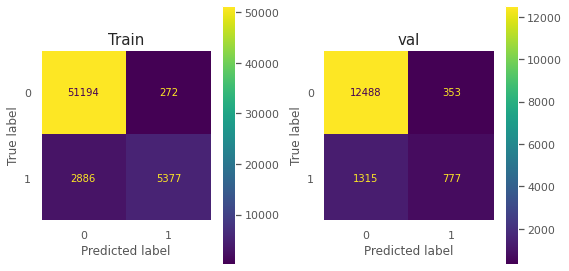

In [38]:

y_train_pred = xgb_RSCV_e.predict(X_train_encoded)
y_val_pred = xgb_RSCV_e.predict(X_val_encoded)

# roc_curve(타겟값, prob of 1)
y_pred_proba = xgb_RSCV_e.predict_proba(X_val_encoded)[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_proba)

# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[optimal_idx]

# threshold 최대값으로 설정 
y_pred_optimal = y_pred_proba >= optimal_threshold

print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal)*100 ,"%")
print('최종 f1 score',f1_score(y_val, y_pred_optimal)*100 ,"%")
print("\nConfusion matrix: \n")

#Roc 그래프
fig, ax = plt.subplots(1,2, figsize=(8,4))
plot_confusion_matrix(xgb_RSCV_e,X_train_encoded,y_train, ax=ax[0], values_format='d')
ax[0].grid(False)
ax[0].set_title('Train',fontsize=15)
plot_confusion_matrix(xgb_RSCV_e,X_val_encoded,y_val, ax=ax[1], values_format='d')
ax[1].set_title('val',fontsize=15)
ax[1].grid(False)
plt.tight_layout()

In [78]:
print('검증 정확도', xgb_RSCV_e.score(X_val_encoded, y_val)*100,'%')
print('검증 f1 score: ', f1_score(y_val, xgb_RSCV_e.predict(X_val_encoded))*100,'%')

검증 정확도 88.83010781490658 %
검증 f1 score:  48.23091247672253 %


auc_score : 88.4260211264617


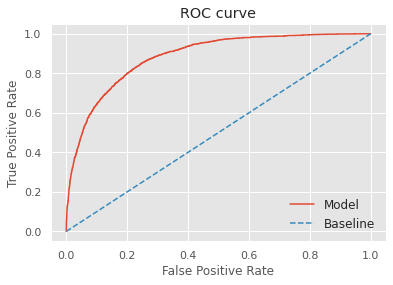

In [80]:
y_pred_proba = xgb_RSCV_e.predict_proba(X_val_encoded)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)
fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))

plt.style.use("ggplot")
plt.plot(fpr, tpr, label="Model")
plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.title("ROC curve")
plt.legend(prop={"size": 12})
print("auc_score :",auc_score*100)
plt.show()

- Xgboost 모델에 RandomizedSearchCV에 Early Stopping을 적용하여 과접합을 줄인 모델을 만들었습니다.
- 검증 정확도 88.83%으로 최빈값 86.1%를 넘는 모델을 만들었으며 auc 점수 88.43으로 최고값을 얻었습니다. 

## 모델 종합 성능 평가

In [86]:
from prettytable import PrettyTable
print('\nWithout Dimensionality reduction\n')

table1 = PrettyTable()
table1.field_names = ['Algorithm','val accuracy ', 'val auc score']
table1.add_row(['SGDC model',53.77,59.83])
table1.add_row(['DecisionTree',70.13,73.39])
table1.add_row(['Random Forest',71.81,73.49 ])
table1.add_row(['Random Forest RSCV', 74.50,75.49])
table1.add_row(['XGBoost',80.60,78.53])
table1.add_row(['XGBoost RSCV', 80.88,81.08])
table1.add_row(['XGBoost RSCV Early stopping',88.83, 88.42])
print(table1.get_string(title='Original dataset'))


Without Dimensionality reduction

+-------------------------------------------------------------+
|                       Original dataset                      |
+-----------------------------+---------------+---------------+
|          Algorithm          | val accuracy  | val auc score |
+-----------------------------+---------------+---------------+
|          SGDC model         |     53.77     |     59.83     |
|         DecisionTree        |     70.13     |     73.39     |
|        Random Forest        |     71.81     |     73.49     |
|      Random Forest RSCV     |      74.5     |     75.49     |
|           XGBoost           |      80.6     |     78.53     |
|         XGBoost RSCV        |     80.88     |     81.08     |
| XGBoost RSCV Early stopping |     88.83     |     88.42     |
+-----------------------------+---------------+---------------+


## 테스트 데이터 성능 확인 

In [ ]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) 
X_test_encoded = encoder.transform(X_test) 

xgb_RSCV_es =  XGBClassifier(  
                    min_child_weight =16
                  , n_estimators=172
                  , random_state=42
                  , n_jobs=-1
                  , max_depth= 20
                  , learning_rate=0.1
                  , colsample_bytree = 0.5
                  #, max_features =  0.48639096261531867
                  #, scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum() *100
                 )

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

xgb_RSCV_es.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', 
          early_stopping_rounds=50
         )

최종 검증 정확도:  80.06535947712419 %
최종 f1 score 53.976499690785396 %

Confusion matrix: 



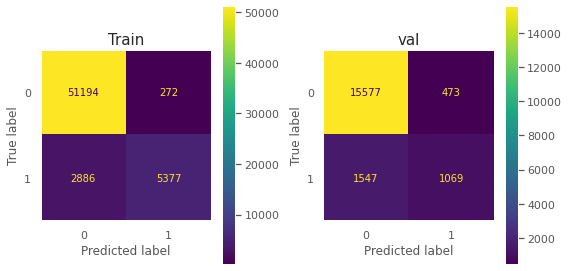

In [45]:
y_train_pred = xgb_RSCV_es.predict(X_train_encoded)
y_val_pred = xgb_RSCV_es.predict(X_test_encoded)

# roc_curve(타겟값, prob of 1)
y_pred_proba = xgb_RSCV_es.predict_proba(X_test_encoded)[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba)

# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[optimal_idx]

# threshold 최대값으로 설정 
y_pred_optimal = y_pred_proba >= optimal_threshold

print('최종 검증 정확도: ', accuracy_score(y_test, y_pred_optimal)*100 ,"%")
print('최종 f1 score',f1_score(y_test, y_pred_optimal)*100 ,"%")
print("\nConfusion matrix: \n")

#Roc 그래프
fig, ax = plt.subplots(1,2, figsize=(8,4))
plot_confusion_matrix(xgb_RSCV_es,X_train_encoded,y_train, ax=ax[0], values_format='d')
ax[0].grid(False)
ax[0].set_title('Train',fontsize=15)
plot_confusion_matrix(xgb_RSCV_es,X_test_encoded,y_test, ax=ax[1], values_format='d')
ax[1].set_title('val',fontsize=15)
ax[1].grid(False)
plt.tight_layout()

In [43]:
print('테스트 정확도', xgb_RSCV_es.score(X_test_encoded, y_test)*100,'%')
print('테스트 f1 score: ', f1_score(y_test, xgb_RSCV_es.predict(X_test_encoded))*100,'%')

테스트 정확도 89.17818493517625 %
테스트 f1 score:  51.41895141895142 %


auc_score : 89.38653457753388


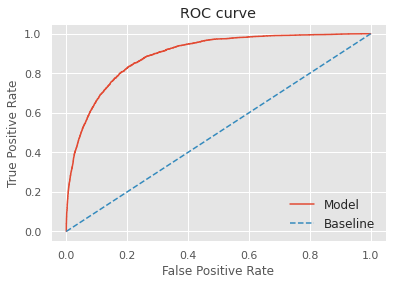

In [41]:
y_pred_proba = xgb_RSCV_es.predict_proba(X_test_encoded)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, [0] * len(y_test))

plt.style.use("ggplot")
plt.plot(fpr, tpr, label="Model")
plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline")
plt.xlabel("False Positive Rate", size=12)
plt.ylabel("True Positive Rate", size=12)
plt.title("ROC curve")
plt.legend(prop={"size": 12})
print("auc_score :",auc_score*100)
plt.show()

- 테스트 데이터를 통해 학습한 결과 만족할 만큼 성능이 나왔습니다.
- 테스트 데이터에서 과적합되지 않고 일반화가 잘 됐다고 볼 수 있습니다. 
- auc 점수 89.38점을 얻어 검증 데이터보다 좋은 결과를 얻었습니다.
- 최종적으로  89.18%의 정확도로 충성 고객 여부를 예측하는 모델을 완성시켰습니다.


# 모델 해석


## Permutation Importance

In [32]:
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) 
X_test_encoded = encoder.transform(X_test) 

xgb_RSCV_es =  XGBClassifier(  
                    min_child_weight =16
                  , n_estimators=172
                  , random_state=42
                  , n_jobs=-1
                  , max_depth= 20
                  , learning_rate=0.1
                  , colsample_bytree = 0.5
                  #, max_features =  0.48639096261531867
                  #, scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum() *100
                 )

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

xgb_RSCV_es.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', 
          early_stopping_rounds=50
         )

[0]	validation_0-error:0.12431	validation_1-error:0.13174
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.12753	validation_1-error:0.13227
[2]	validation_0-error:0.12584	validation_1-error:0.12954
[3]	validation_0-error:0.12404	validation_1-error:0.12890
[4]	validation_0-error:0.12257	validation_1-error:0.12847
[5]	validation_0-error:0.12235	validation_1-error:0.12911
[6]	validation_0-error:0.12167	validation_1-error:0.12809
[7]	validation_0-error:0.12073	validation_1-error:0.12756
[8]	validation_0-error:0.11932	validation_1-error:0.12676
[9]	validation_0-error:0.11944	validation_1-error:0.12804
[10]	validation_0-error:0.11845	validation_1-error:0.12697
[11]	validation_0-error:0.11864	validation_1-error:0.12906
[12]	validation_0-error:0.11850	validation_1-error:0.12911
[13]	validation_0-error:0.11611	validation_1-error:0.12734
[14]	validation_0-error

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=16, missing=nan, monotone_constraints=None,
              n_estimators=172, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [33]:
permuter = PermutationImportance(
    xgb_RSCV_es, 
    scoring='accuracy', 
    n_iter=5,
    random_state=2
)
permuter.fit(X_test_encoded, y_test);
feature_names = X_test_encoded.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)


- 지출액이 model에 큰 영향을 끼친 것을 알 수 있습니다..
- 다음으로 상품의 판매 금액이 충성고객을 예측하는데 큰 영향을 끼쳤습니다..
- 항목 운임 금액으로 전체적인 금액이 비싼 물건을 구매한 고객이 충성 고객일 있습니다.

## Feature selection

In [34]:
print('특성 삭제 전:', X_train.shape, X_test.shape)
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_test_selected = X_test[features]
print('특성 삭제 후:', X_train_selected.shape, X_test_selected.shape)

특성 삭제 전: (59729, 16) (18666, 16)
특성 삭제 후: (59729, 9) (18666, 9)


In [35]:
# 특성 삭제 후 모델링
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train_selected) 
X_test_encoded = encoder.transform(X_test_selected) 

xgb_RSCV_es_f =  XGBClassifier(  
                    min_child_weight =16
                  , n_estimators=172
                  , random_state=42
                  , n_jobs=-1
                  , max_depth= 20
                  , learning_rate=0.1
                  , colsample_bytree = 0.5
                  #, max_features =  0.48639096261531867
                  #, scale_pos_weight=(y_train == 1).sum() / (y_train == 0).sum() *100
                 )

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]

xgb_RSCV_es_f.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', 
          early_stopping_rounds=50
         )

[0]	validation_0-error:0.12925	validation_1-error:0.14352
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.12361	validation_1-error:0.13372
[2]	validation_0-error:0.12433	validation_1-error:0.12938
[3]	validation_0-error:0.12528	validation_1-error:0.12933
[4]	validation_0-error:0.12468	validation_1-error:0.12836
[5]	validation_0-error:0.12347	validation_1-error:0.12868
[6]	validation_0-error:0.12361	validation_1-error:0.12911
[7]	validation_0-error:0.12160	validation_1-error:0.12793
[8]	validation_0-error:0.12170	validation_1-error:0.12831
[9]	validation_0-error:0.12229	validation_1-error:0.12938
[10]	validation_0-error:0.12207	validation_1-error:0.12986
[11]	validation_0-error:0.12215	validation_1-error:0.13051
[12]	validation_0-error:0.12167	validation_1-error:0.13013
[13]	validation_0-error:0.12091	validation_1-error:0.12906
[14]	validation_0-error

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=20,
              min_child_weight=16, missing=nan, monotone_constraints=None,
              n_estimators=172, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

최종 검증 정확도:  78.98853530483233 %
최종 f1 score 53.84796422687691 %

Confusion matrix: 



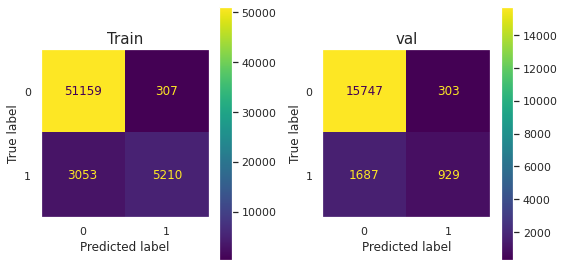

In [36]:
y_train_pred = xgb_RSCV_es_f.predict(X_train_encoded)
y_val_pred = xgb_RSCV_es_f.predict(X_test_encoded)

# roc_curve(타겟값, prob of 1)
y_pred_proba = xgb_RSCV_es_f.predict_proba(X_test_encoded)[:, 1]
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred_proba)

# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr1 - fpr1)
optimal_threshold = thresholds1[optimal_idx]

# threshold 최대값으로 설정 
y_pred_optimal = y_pred_proba >= optimal_threshold

print('최종 검증 정확도: ', accuracy_score(y_test, y_pred_optimal)*100 ,"%")
print('최종 f1 score',f1_score(y_test, y_pred_optimal)*100 ,"%")
print("\nConfusion matrix: \n")

#Roc 그래프
fig, ax = plt.subplots(1,2, figsize=(8,4))
plot_confusion_matrix(xgb_RSCV_es_f,X_train_encoded,y_train, ax=ax[0], values_format='d')
ax[0].grid(False)
ax[0].set_title('Train',fontsize=15)
plot_confusion_matrix(xgb_RSCV_es_f,X_test_encoded,y_test, ax=ax[1], values_format='d')
ax[1].set_title('val',fontsize=15)
ax[1].grid(False)
plt.tight_layout()

In [37]:
print('테스트 정확도', xgb_RSCV_es_f.score(X_test_encoded, y_test)*100,'%')
print('테스트 f1 score: ', f1_score(y_test, xgb_RSCV_es_f.predict(X_test_encoded))*100,'%')

테스트 정확도 89.33890496089147 %
테스트 f1 score:  48.28482328482328 %


auc_score : 90.27126144407289


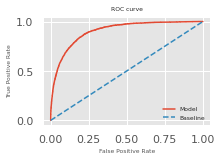

In [38]:
y_pred_proba = xgb_RSCV_es_f.predict_proba(X_test_encoded)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
baseline_fpr, baseline_tpr, _ = roc_curve(y_test, [0] * len(y_test))


plt.style.use("ggplot")
plt.figure(figsize=(3,2))
plt.plot(fpr, tpr, label="Model")
plt.plot(baseline_fpr, baseline_tpr, linestyle="--", label="Baseline" )
plt.xlabel("False Positive Rate", size=6)
plt.ylabel("True Positive Rate", size=6)
plt.title("ROC curve", size=6)
plt.legend(prop={"size": 6})
print("auc_score :",auc_score*100)
plt.show()

- 상관관계가 떨어지는 칼럼들을 삭제한 후 auc 점수가 1점 향상시킬수 있었습니다. 

## PDP plot

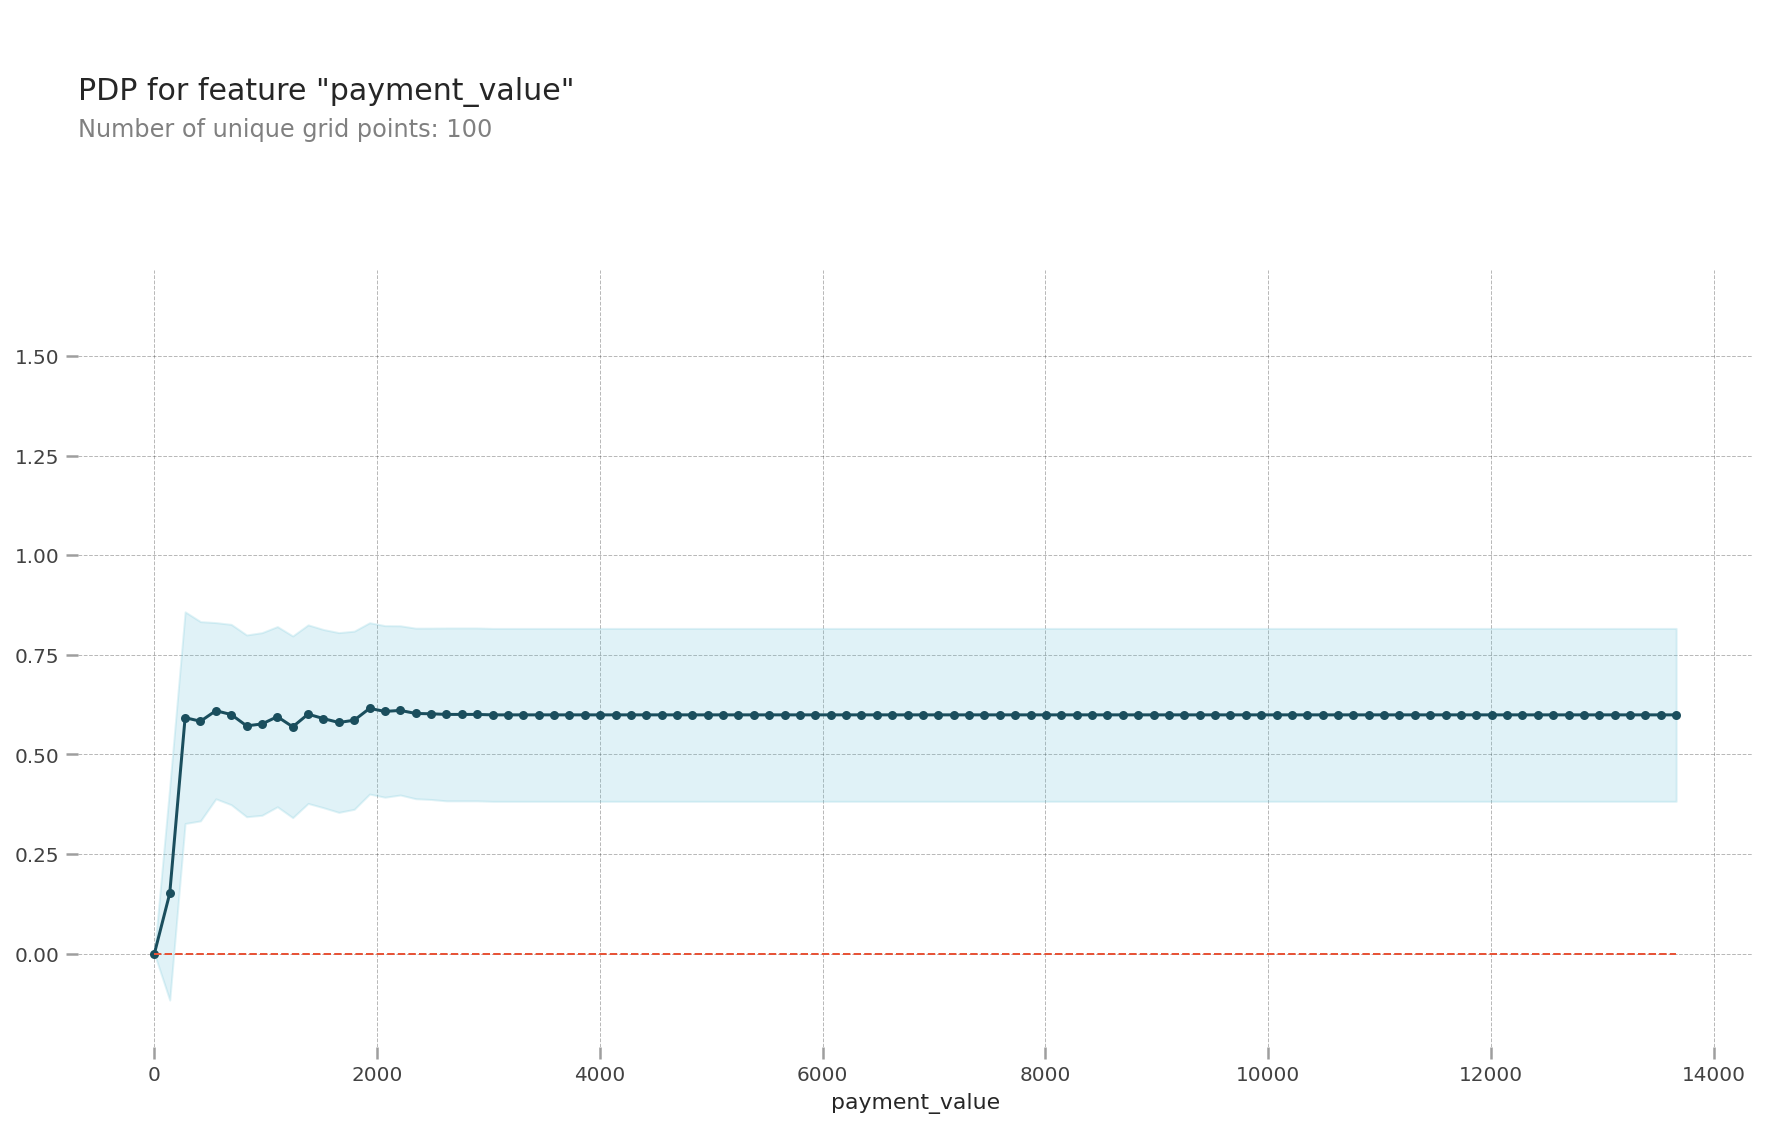

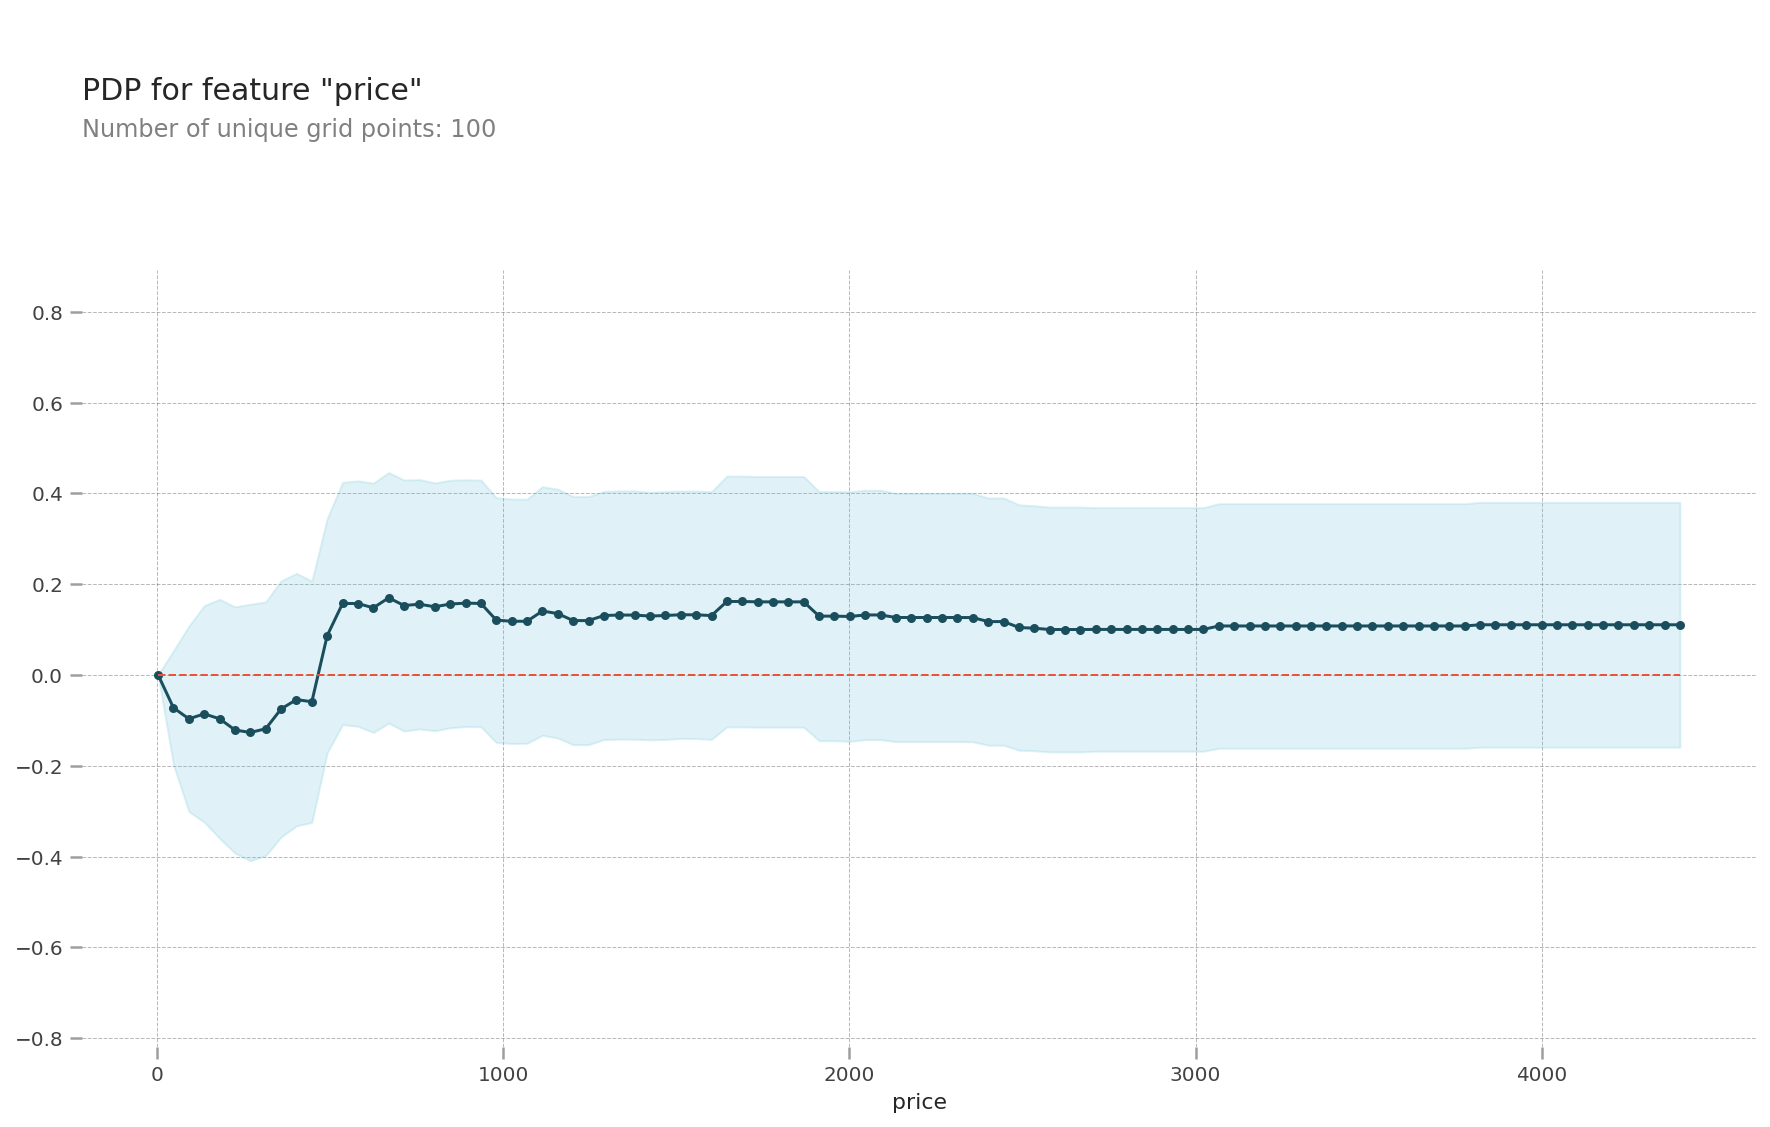

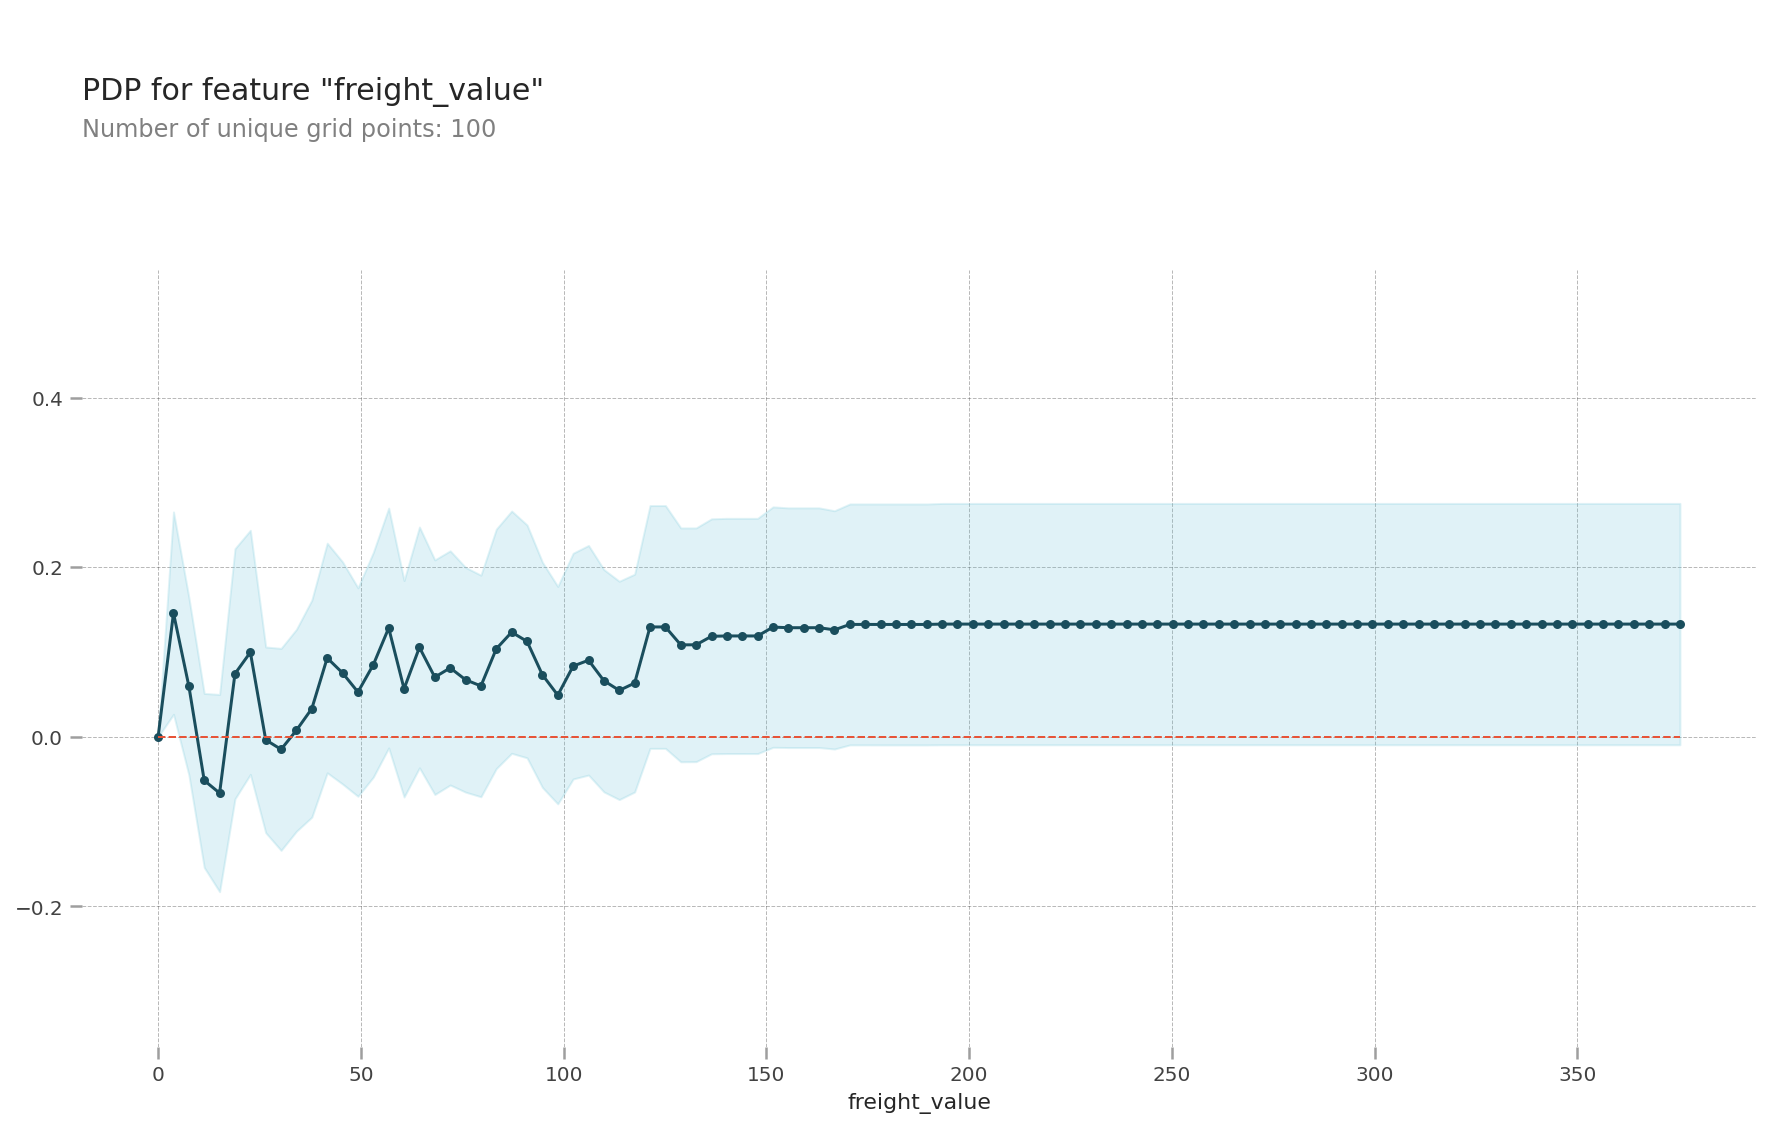

In [132]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'payment_value'
isolated = pdp_isolate(
    model=xgb_RSCV, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='equal', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);
feature = 'price'
isolated = pdp_isolate(
    model=xgb_RSCV, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='equal', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);

feature = 'freight_value'
isolated = pdp_isolate(
    model=xgb_RSCV, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature,
    grid_type='equal', # default='percentile', or 'equal'
    num_grid_points=100 # default=10
)
pdp_plot(isolated, feature_name=feature);

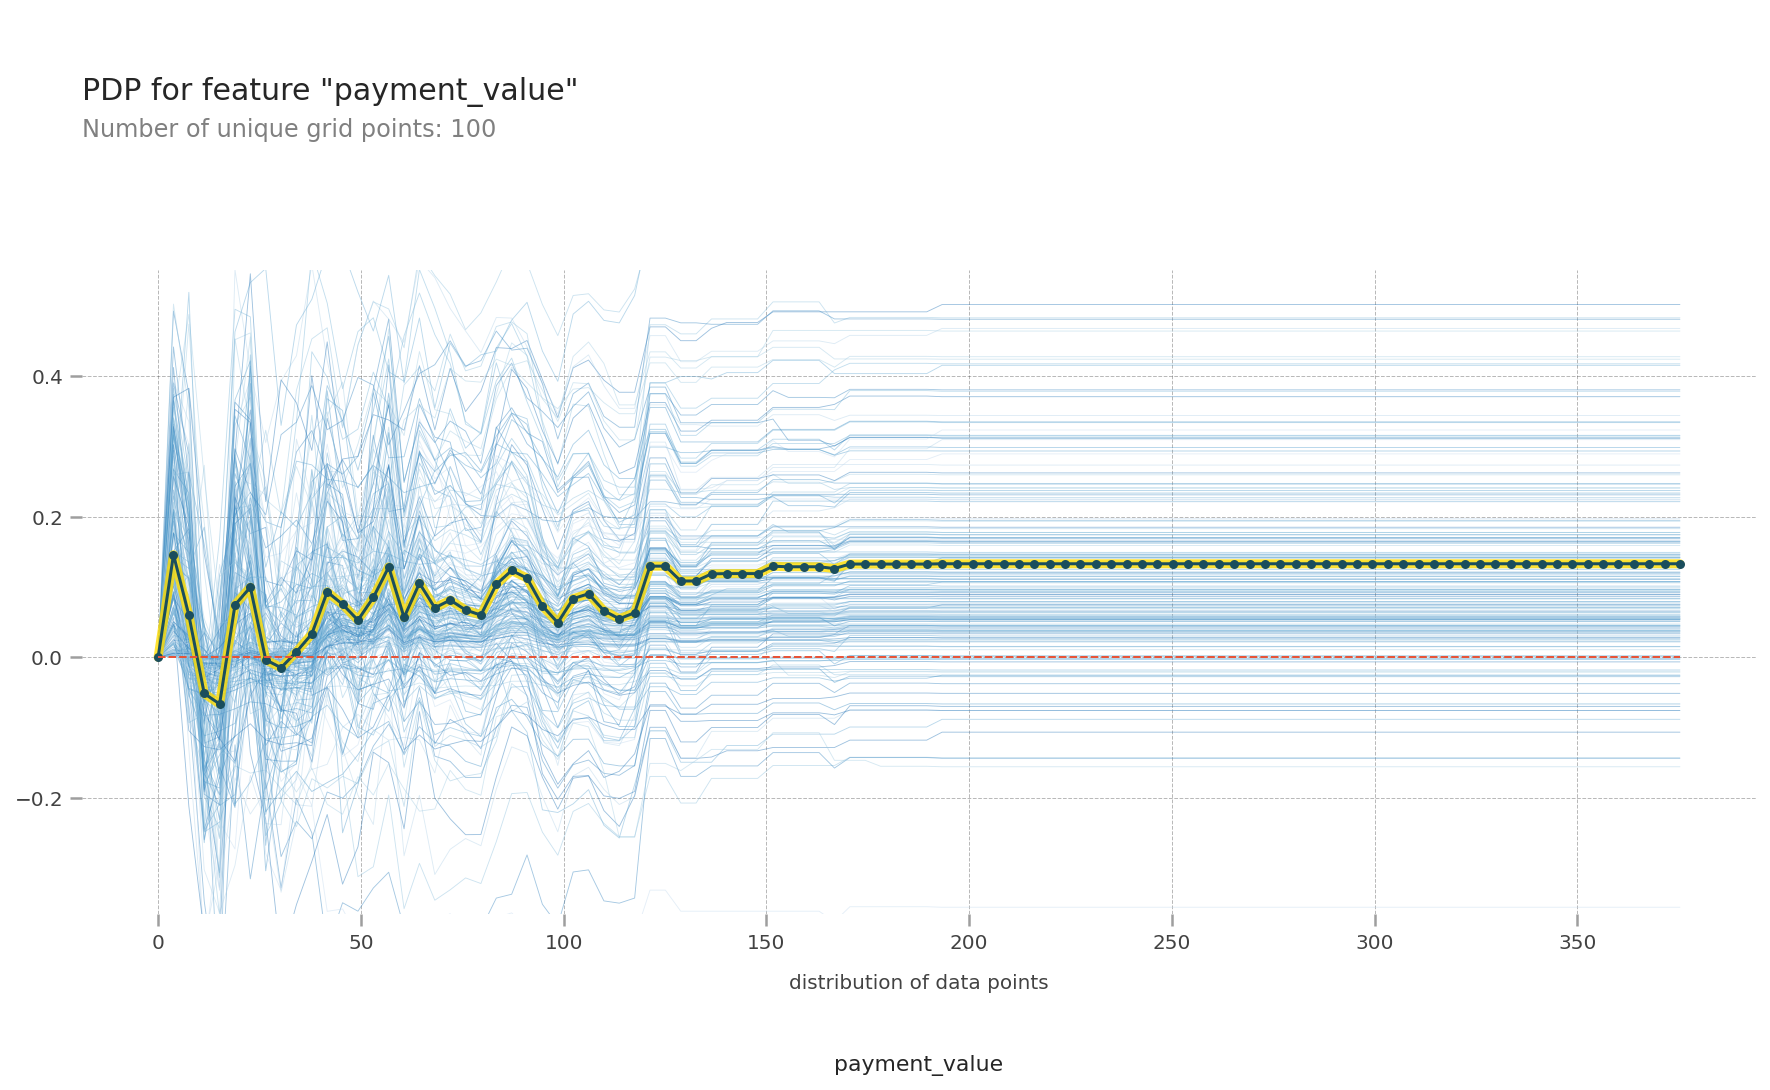

In [133]:
pdp_plot(isolated
         , feature_name='payment_value'
         , plot_lines=True # ICE plots
         , frac_to_plot=0.01 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

### 2가지 특성 PDP

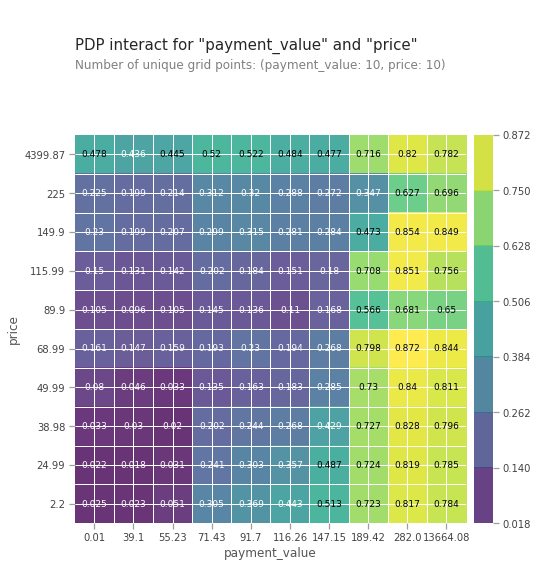

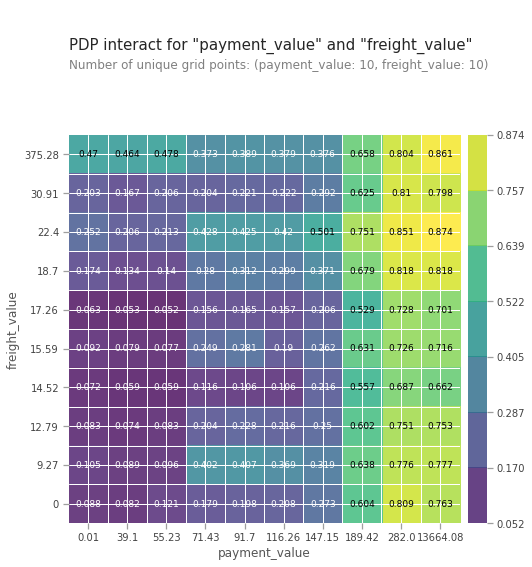

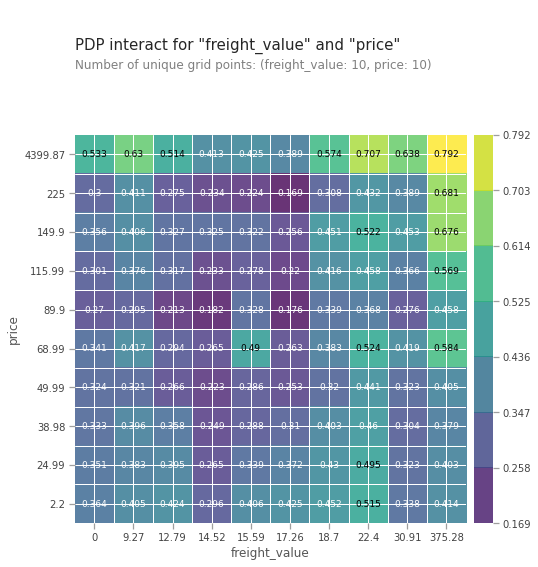

In [59]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['payment_value', 'price']

interaction = pdp_interact(
    model=xgb_RSCV, 
    dataset=X_test,
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

features = ['payment_value', 'freight_value']

interaction = pdp_interact(
    model=xgb_RSCV, 
    dataset=X_test,
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

features = ['freight_value', 'price']

interaction = pdp_interact(
    model=xgb_RSCV, 
    dataset=X_test,
    model_features=X_test.columns, 
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

(<Figure size 1080x1368 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f899994f520>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f89998fc3d0>})

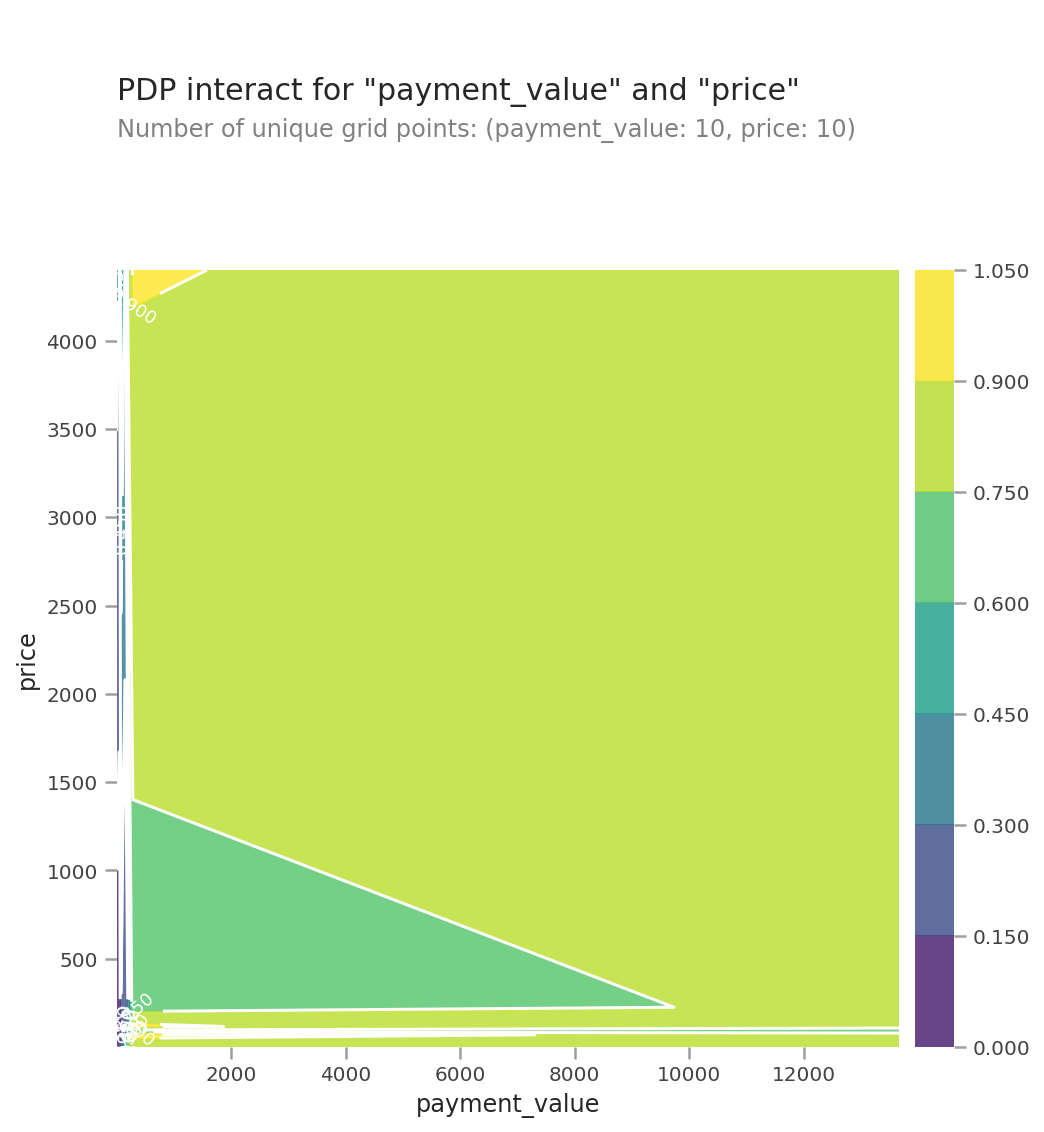

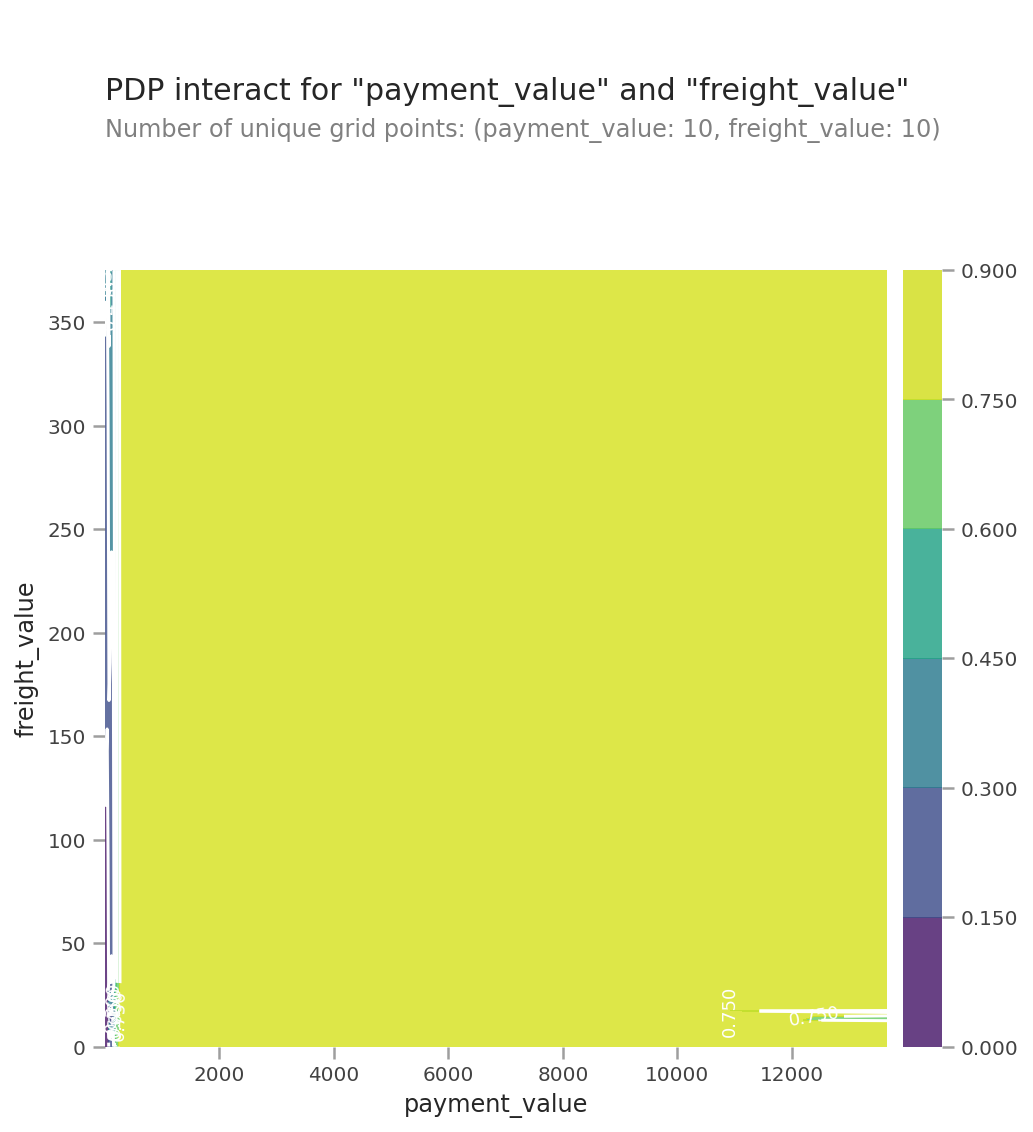

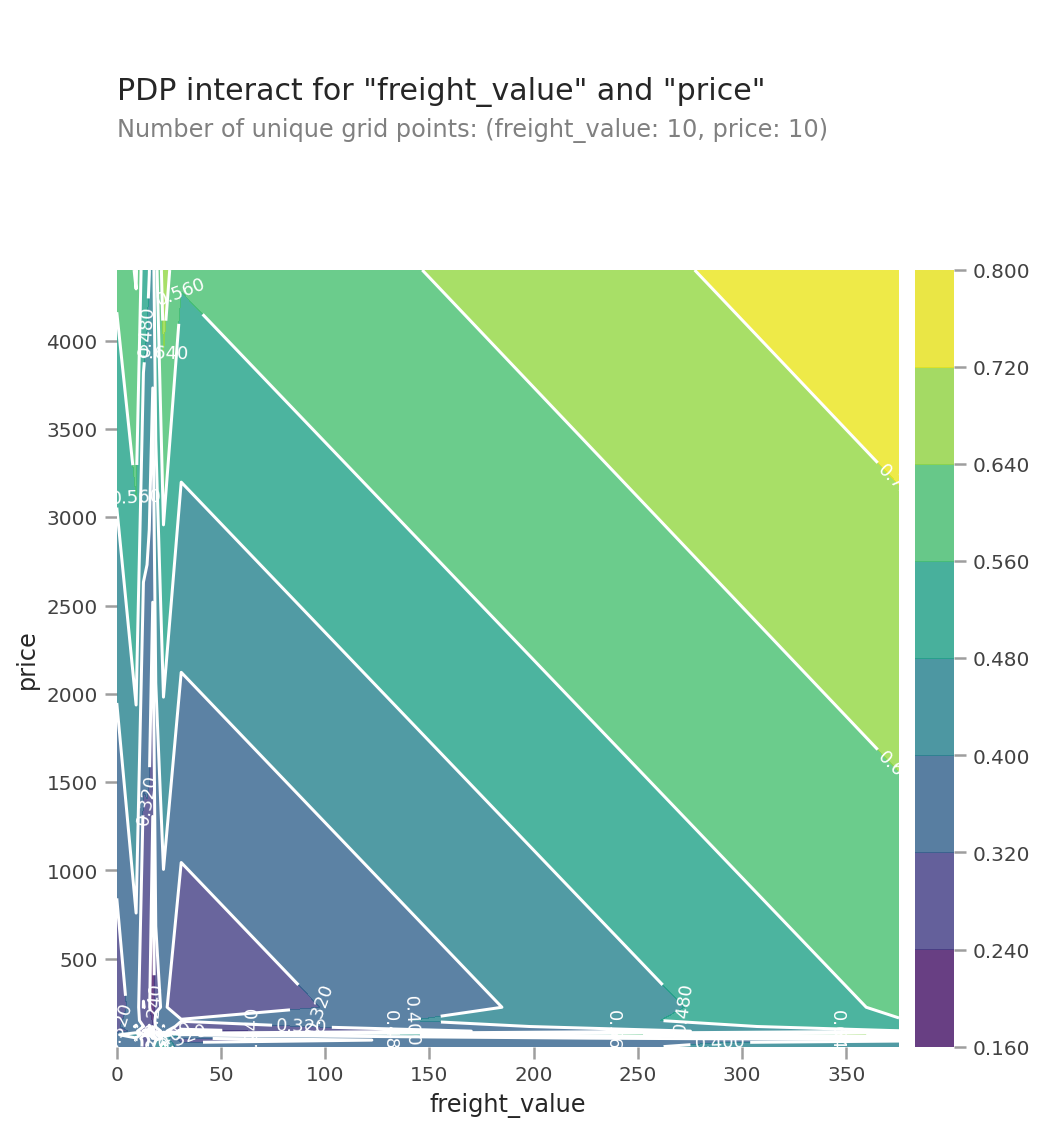

In [135]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

interact = pdp_interact(
    model = xgb_RSCV,
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=['payment_value', 'price']
)

pdp_interact_plot(
    pdp_interact_out=interact,
    feature_names=['payment_value', 'price'],
    plot_type='contour',
    x_quantile=False,
    plot_pdp=False
)

interact = pdp_interact(
    model = xgb_RSCV,
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=['payment_value', 'freight_value']
)

pdp_interact_plot(
    pdp_interact_out=interact,
    feature_names=['payment_value', 'freight_value'],
    plot_type='contour',
    x_quantile=False,
    plot_pdp=False
)

interact = pdp_interact(
    model = xgb_RSCV,
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=['freight_value', 'price']
)

pdp_interact_plot(
    pdp_interact_out=interact,
    feature_names=['freight_value', 'price'],
    plot_type='contour',
    x_quantile=False,
    plot_pdp=False
)

## SHAP

In [40]:
processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)
processor.fit(X_train_selected,y_train)
row = X_test_selected.iloc[:100]  

import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_RSCV_es_f)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)
shap.force_plot(explainer.expected_value, shap_values,row_processed)

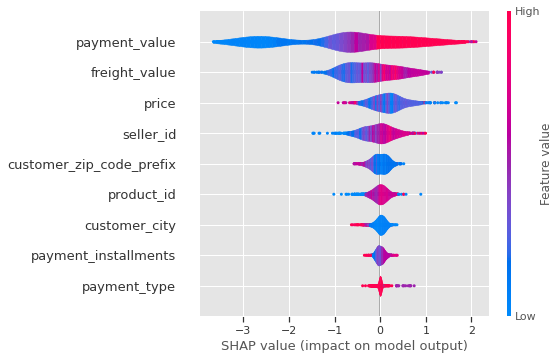

In [50]:
row = X_test_selected.sample(1000,random_state=42) 
shap.initjs()
explainer = shap.TreeExplainer(xgb_RSCV_es_f)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)
shap.summary_plot(shap_values, row_processed,feature_names=X_test_selected.columns,plot_type="violin")

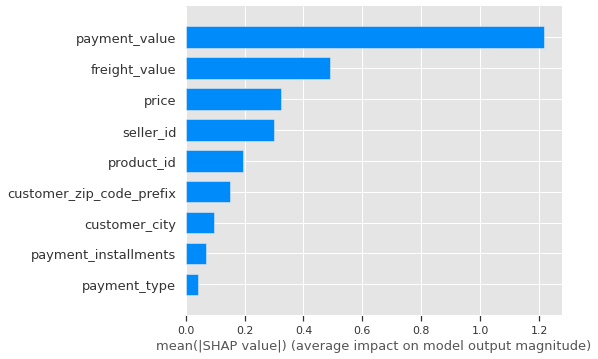

In [49]:
# type ber
row = X_test_selected.sample(1000,random_state=42) 
shap.initjs()
explainer = shap.TreeExplainer(xgb_RSCV_es_f)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)
shap.summary_plot(shap_values, row_processed,feature_names=X_test_selected.columns ,plot_type="bar")

In [225]:
X_test_selected[['price','freight_value','payment_value']].agg(['min','max','mean','median'])

price  freight_value  payment_value
min        2.200000       0.000000       0.010000
max     4399.870000     375.280000   13664.080000
mean     126.408256      20.147957     158.944133
median    79.000000      16.350000     103.370000

In [245]:
# 전체 지출액 평균 158인 고객 
row = X_test_selected.loc[[40789]]
explainer = shap.Explainer(xgb_RSCV_es_f)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' 
)

- 아래 3가지 특성의 영향을 받아 충성 고객 여부를 예측하였습니다.
  - 지출액: 159BRL 
  - 운임 요금: 19.08BRL
  - 상품 가격 : 139.8BRL
- 평균적인 지출액(158BRL)을 소비한 고객에 대해서 82%의 확률로 충성고객이 아닌 것으로 예측하였습니다.

- 

In [243]:
# 최고 지출액 고객
row = X_test_selected.loc[[3723]]
explainer = shap.Explainer(xgb_RSCV_es)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' 
)

- 아래 3가지 특성의 영향을 받아 충성 고객 여부를 예측하였습니다.
  - 지출액: 13664.08BRL 
  - 판매자 아이디
  - 운임요금 : 28.01BRL
- 위 고객을 충성 고객으로 예측할 확률은 60%입니다.
- 보통 고객과는 다르게 최고 금액을 구매한 고객에게 두번째로 영향을 미치는 특성이 판매자 아이디였습니다.
- 이는 판매자가 특정한 고가의 상품을 판매하며 그 물건을 사는 고객이 충성 고객일 수 있다고 볼 수 있습니다. 

In [183]:
# 평균 지출액 고객 데이터 
xgb_test = X_test[['customer_unique_id','payment_value']].sort_values(by='payment_value')
xgb_test[xgb_test['payment_value'] >= xgb_test['payment_value'].mean()].head()

customer_unique_id  payment_value
34061  5d19139a14cc83b4d1b9a6ad9af11147         158.98
20841  38fc890f517a8327ca25ef4b190fcc29         158.99
41226  70de18a43c8f5f238d095ebeeb6e7dd0         159.02
40789  6fa75bcd8374aaf022bf590a4aad45e2         159.03
10052  1b68f8121b314ef1bf621efbde6b7cb9         159.03

In [184]:
# 최고 지출액 고객 
xgb_test.tail()

customer_unique_id  payment_value
75246  ce3fe361f9e68bf0a813baaae1334d01        3351.35
54493  95a744604de66a2e40e18086e69be4f2        3406.47
68750  bc5e25094a7d51b6aee35236572e64f4        3826.80
86827  edde2314c6c30e864a128ac95d6b2112        4513.32
3723   0a0a92112bd4c708ca5fde585afaa872       13664.08